# Content 

This notebook contains an example of voltage optimization for ion shuttling and MD simulation of this shuttling. The route of the shuttling is optimized according to the principles, listed in 
https://doi.org/10.48550/arXiv.quant-ph/0702175.

In general, the similar approach can be applied to any simulation of surface trap with time-varying voltages.

In [2]:
import matplotlib.pyplot as plt, numpy as np, scipy, scipy.constants as ct
from __future__ import division
from electrode import (System, PolygonPixelElectrode, euler_matrix,
    PointPixelElectrode, PotentialObjective,
    PatternRangeConstraint, shaped)
import sion as sn
import sys
from pathlib import Path
import pylion as pl
import time

#puts python plots inline with the code
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Trap definition

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Distance from RF minimum: [0.    0.004 0.003] um
secular frequencies: (0.6879, 2.243, 2.914) MHz
in directions
a: [ 1.  0. -0.] 
b: [ 0.00000000e+00 -9.99999995e-01  9.98987372e-05] 
c: [ 0.00000000e+00 -9.98987372e-05 -9.99999995e-01]


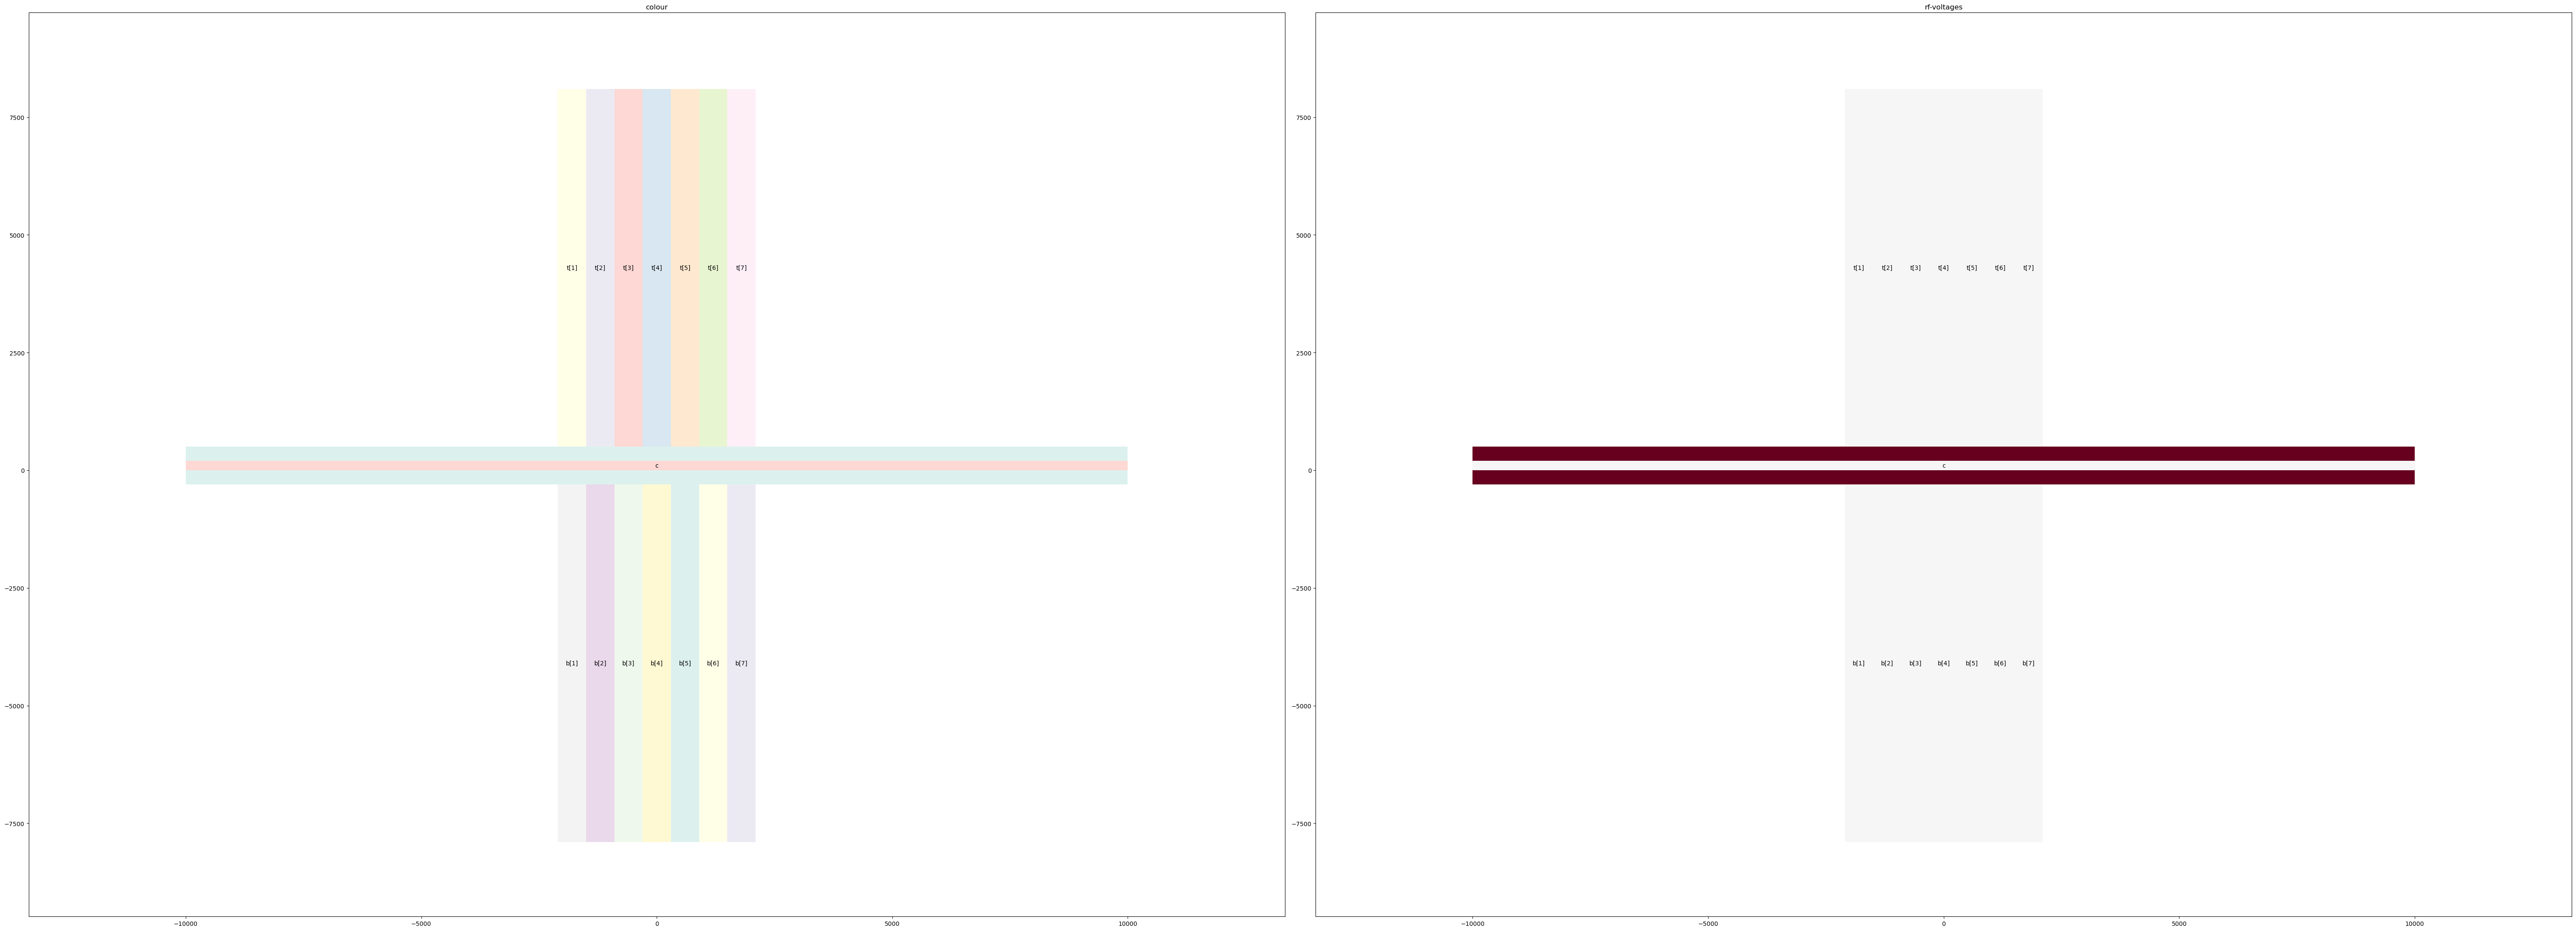

In [69]:
# define trap with large anharmonicity 
L = 1e-6 # length scale
Vrf = 160# RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*20e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)


# parameters of trap
DCtop = [[7600, 600]  ]  # Array of lengths and widths of Top electrodes
DCbottom = [[7600, 600]]  # Array of lengths and widths of Bottom electrodes
cwidth = 200# Width of central dc electrode
clength = 20000 # length of central dc electrode
boardwidth = 0  # width of gaps between electrodes
rftop = 300  # width of top rf electrode, not including width of central electrode
rflength = 20000  # length of rf electrodes
rfbottom = 300  # width of bottom rf electrode

s, RF_coordinates, DC_coordinates = sn.five_wire_trap_design(Urf, DCtop ,DCbottom, cwidth, clength, boardwidth, rftop, rflength, rfbottom, patternTop = 7, patternBot = 7, need_coordinates = True, need_plot = True, save_plot = 'images/linear_shuttling_trap.eps')

x1 = np.array(s.minimum((0., 2, 3), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))

u_set = np.array([0, 0, 10, 10, -10, 10,10, 0, 0, 10, 10, -10, 10,10, 0, 1.902])
dc_set = u_set[1:]

with s.with_voltages(dcs = u_set, rfs = None):
    x0 = np.array(s.minimum(x1*1.0001, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
    print(f'Distance from RF minimum: {np.round(x0-x1, 3)} um')
    curv_z, mod_dir=s.modes(x0 ,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("in directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    #print(sn.anharmonics(sist, [x1], 0, L))


# Shuttling process

We will start from the position -5 mkm, and shuttle ion by 10 mkm in axial direction. In general it is beneficial to separate the full shuttling distance into steps with smaller shuttling distance. *Sion* optimizes voltage sequence on DC electrodes to perform shuttling according to the tanh route with the conversion of the axial secular frequency to minimize heating. 

The following block performs voltage optimization (*sion.linear_shuttling_voltage()*) and mapping of voltage sequence to the analytic functions, suitable for optimization (*sion.approx_shuttling()*).

## Expected and resulting x(t) dependency

In [70]:
d = 50
T = 3e-4  #300 us
vmin = -15
vmax = 15
res = 25
L = 1e-6
x_start = x0 - np.array([0, 0, 0]) 
shuttlers = [1,2,4,5,8,9,11,12,14]

start_time = time.time()
voltage_seq, funcs = sn.linear_shuttling_voltage(s, x_start, d, T, dc_set, shuttlers = shuttlers, vmin = vmin, vmax = vmax, res = res, need_func = True)
print("Optimization took:", np.round(time.time()-start_time), "seconds")

volt_seq = voltage_seq.T

Optimization took: 18.0 seconds


C:\Users\User_A\anaconda3\Lib\site-packages\sion-0.5.0-py3.11.egg\sion\sion.py:443: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*(t-c)**2) + d
C:\Users\User_A\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


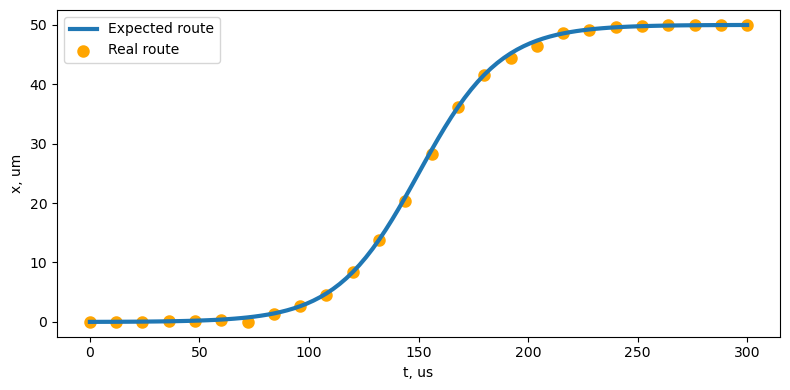

In [75]:
# we wish to obtain the following function of x(t)
def q_tan(t, d, T, a = 0, N = 4):
    return d/2*(np.tanh(N*(2*t-T)/T)/np.tanh(N) + 1) + a*x_start[0] 
# let's calculate real positions of potential minimum at each time step 
xx = []
omegas = []
omegas_z = []

for dt in range(res+1):
    t = dt*T/res
    x = x_start + np.array([q_tan(t, d, T), 0, 0])
    u_set = [0]
    u_set.extend(volt_seq[dt])
    with s.with_voltages(dcs = u_set, rfs = None):
        x1 = s.minimum(x*1.001, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
        xx.append(x1[0])
        curv_z, mod_dir=s.modes(x,sorted=False)
        omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
        omegas.append(omega_sec[0])
        omegas_z.append(omega_sec[2])
        
fig = plt.figure(figsize = [8,4])
plt.plot(np.arange(101)*T/100, q_tan(np.arange(101)*T/100, d, T, a = 1) ,linewidth = 3, label = 'Expected route')
plt.scatter(np.arange(res+1)*T/res, xx,linewidth = 3, color = 'orange', label = 'Real route')
plt.xticks([0, 50e-6, 100e-6, 150e-6, 200e-6, 250e-6, 300e-6], [0, 50, 100, 150, 200, 250, 300])
plt.xlabel('t, us')
plt.ylabel('x, um')
plt.legend()

plt.tight_layout()
plt.savefig('images/linear_expected_route.eps')
plt.show()

## Axial secular frequency conserving

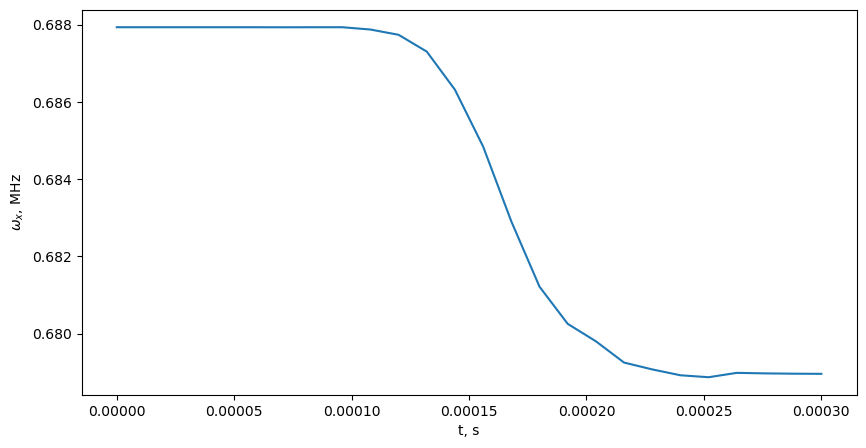

In [6]:
fig = plt.figure(figsize = [10,5])
plt.plot(np.arange(res+1)*T/res, omegas)

plt.xlabel('t, s')
plt.ylabel('$\omega_{x}$, MHz')

plt.show()


## Radial secular frequency

Check variations in radial secular frequency, so it doesn't exceed stability threshold (approximately Omega/3). 

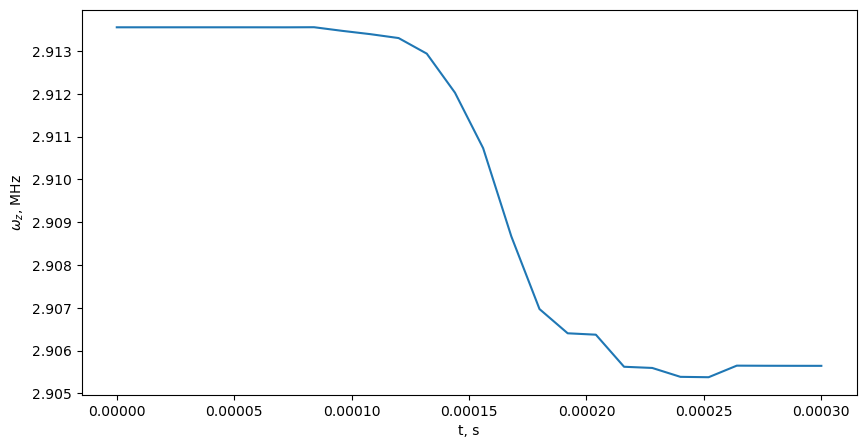

In [7]:
fig = plt.figure(figsize = [10,5])
plt.plot(np.arange(res+1)*T/res, omegas_z)

plt.xlabel('t, s')
plt.ylabel('$\omega_{z}$, MHz')

plt.show()


## Resulting voltage sequence and it's approximation

LAMMPS must obtain analytic time-dependent function to perform correct simulation. That is why it's necessary to get analytic approximation for our DC voltage schedule. *Sion* performs either constant, tanh or normal distribution-like approximations, and fits voltage schedule with the most suitable.

From the form of the V(t) you can see, that you may feed *sion.polygon_shuttling()* function with any analytic expression in string format, where *time* parameter is replaced with "step\*dt" string.  

In [79]:
for i, fun in enumerate(funcs):
    print(i, 'electrode voltage: V(t) =', fun)

0 electrode voltage: V(t) = (0.000)
1 electrode voltage: V(t) = ((0.358686) * (1 - 2/(exp(2*((25946.068578) * (step*dt + (-0.000152)))) + 1)) + (10.355043))
2 electrode voltage: V(t) = ((0.971130) * (1 - 2/(exp(2*((26068.629747) * (step*dt + (-0.000148)))) + 1)) + (10.960485))
3 electrode voltage: V(t) = (-10.000)
4 electrode voltage: V(t) = ((1.173690) * (1 - 2/(exp(2*((-27624.228575) * (step*dt + (-0.000152)))) + 1)) + (8.832103))
5 electrode voltage: V(t) = ((0.351738) * (1 - 2/(exp(2*((-27833.161565) * (step*dt + (-0.000151)))) + 1)) + (9.649768))
6 electrode voltage: V(t) = (0.000)
7 electrode voltage: V(t) = (0.000)
8 electrode voltage: V(t) = ((0.357890) * (1 - 2/(exp(2*((26067.635131) * (step*dt + (-0.000152)))) + 1)) + (10.354355))
9 electrode voltage: V(t) = ((0.981968) * (1 - 2/(exp(2*((25602.033616) * (step*dt + (-0.000149)))) + 1)) + (10.969386))
10 electrode voltage: V(t) = (-10.000)
11 electrode voltage: V(t) = ((1.177442) * (1 - 2/(exp(2*((-27398.502481) * (step*dt + (-

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


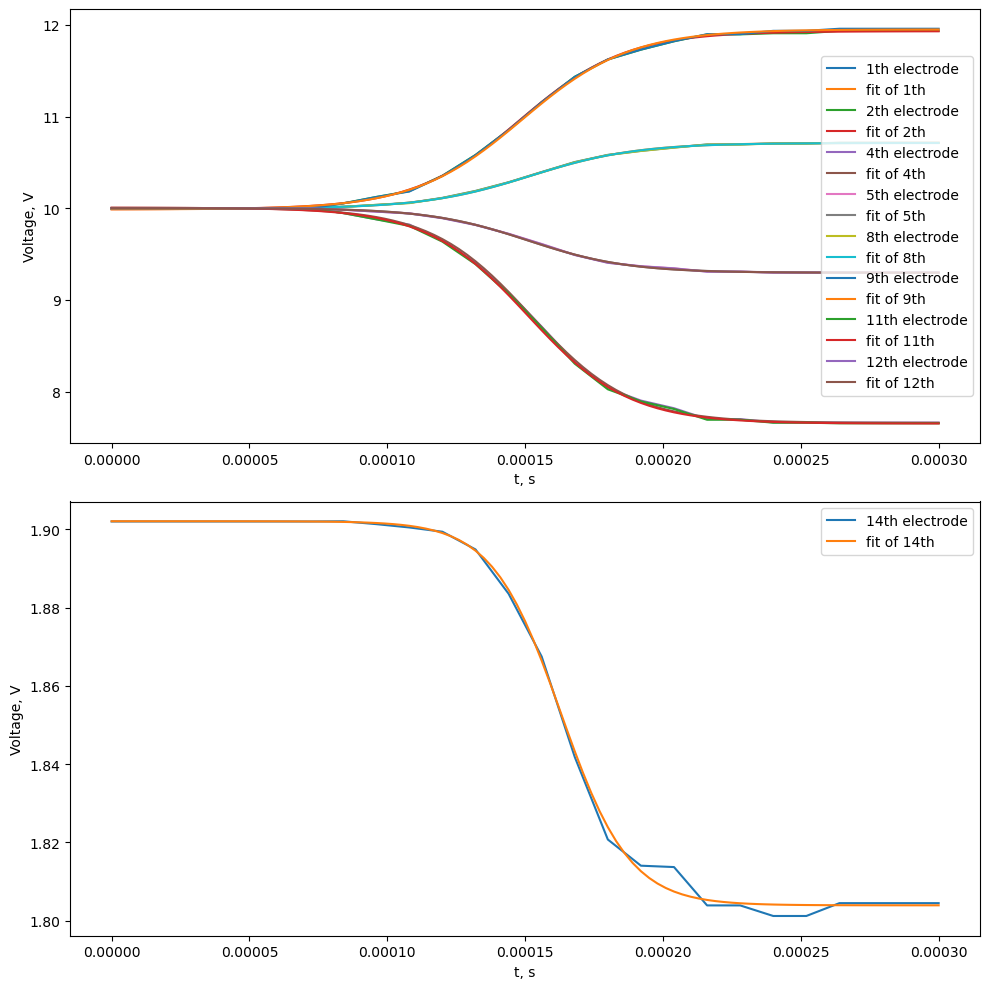

In [87]:
# plot 0th electrode voltage sequence and approximation
def fitter_tan(t,k):
    return eval(funcs[k].replace('step*dt', 't'))

fit_data = np.arange(100+1)*T/100


# real voltage sequences
fig, ax = plt.subplots(2, 1, figsize = [10,10])

for i,seq in enumerate(voltage_seq):
    if i == 1 or i == 2 or i == 8 or i == 9:
        ax[0].plot(np.arange(res+1)*T/res, seq, label = f'{i}th electrode')
        ax[0].plot(fit_data, fitter_tan(fit_data, i), label = f'fit of {i}th')
    if i == 4 or i == 5 or i == 11 or i == 12:
        ax[0].plot(np.arange(res+1)*T/res, seq, label = f'{i}th electrode')
        ax[0].plot(fit_data, fitter_tan(fit_data, i), label = f'fit of {i}th')
    if i == 14:
        ax[1].plot(np.arange(res+1)*T/res, seq, label = f'{i}th electrode')
        ax[1].plot(fit_data, fitter_tan(fit_data, i), label = f'fit of {i}th')
for axi in ax:
    axi.set_xlabel('t, s')
    axi.set_ylabel('Voltage, V')
    axi.legend()
# ax[0].set_ylim(13.8, 14.8)
# ax[1].set_ylim(3.5, 3.6)
plt.tight_layout()
plt.savefig('images/linear_voltage_sequence.eps')
plt.show()

In [16]:
initial_seq = [0]
for i,seq in enumerate(voltage_seq):
    initial_seq.append(fitter_tan(0, i))

with s.with_voltages(dcs = initial_seq, rfs = None):
    x_start = s.minimum(x_start*1.001, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
print(f'Real starting position: {np.round(x_start, 3)} um')

Real starting position: [-5.30000e-02  9.99940e+01  1.99888e+02] um


# Shuttling simulation

The following block performs shuttling simulation with the previously determined voltage sequences on DC electrodes. In general, the *sion.polygon_shuttling()* function performs simulation with arbitrary voltage sequences, approximated with analytic functions, not only shuttling. 

The simulation time is chosen to match the time of shuttling operation, however the choice of fitting functions allows to extend the simulation to the process, where DC voltages stop changing. In Sion one step of simulation corresponds to $1/20\Omega_{RF}$.

In [17]:
positions = np.array(sn.ioncloud_min(x_start, 1, 0))*L

name = Path('shuttling.ipynb').stem

sim = pl.Simulation(name)
#
Caions = {'mass': 40, 'charge': 1}


rf_set = [Vrf, Vrf]
Omegas = [Omega for i in range(2)]

sim.append(pl.placeions(Caions, positions))

sim.append(sn.polygon_shuttling(Omegas, rf_set, RF_coordinates, DC_coordinates, funcs))

sim.append(pl.langevinbath(0, 5e-6))

sim.append(pl.dump('logs\poslinshuttle.txt', variables=['x', 'y', 'z'], steps=10))

t_evolve = int(T*20*Omega)
print(f'Total evolution time: {t_evolve} steps')

sim.append(pl.evolve(t_evolve))

try:
    sim.execute()
except:
    pass

Reducing timestep to 3.978873577297384e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Setting atom values ...
  1 settings made for charge
1 atoms in group 1
1 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 3.97887e-10
Per MPI rank memory allocation (min/avg/max) = 1.405 | 1.405 | 1.405 Mbytes
Step CPU 
       0            0 
   10000     59.4813

C:\Users\User_A\anaconda3\Lib\site-packages\pylion-0.5.2-py3.11.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


## Plot of ion trajectory

C:\Users\User_A\AppData\Local\Temp\ipykernel_4016\1566527011.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


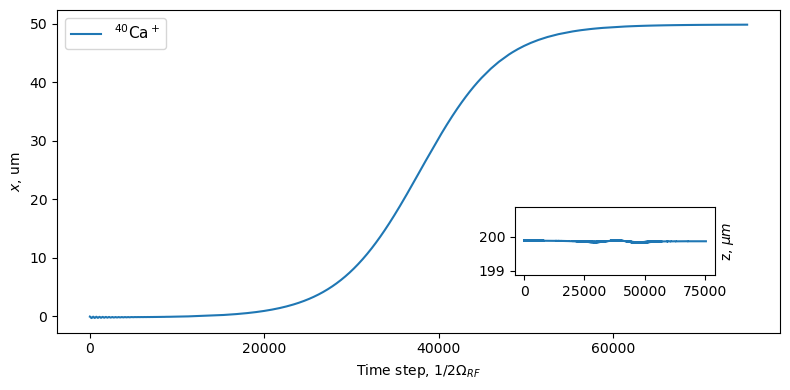

In [84]:
_, data = pl.readdump('logs\poslinshuttle.txt')
data *=1e6

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

#plotting routine
fig, ax = plt.subplots(1,1,figsize = [8, 4] )
ax.plot(data[:, 0, 0], label = '$^{40}$Ca$^+$')
plt.locator_params(axis='x', nbins=5)
ax.legend(prop = {'size': 11}, ncol = 2)
ax.tick_params(axis='both', which='major')
left, bottom, width, height = [0.65, 0.3, 0.25, 0.17]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(data[:, 0, 2])
ax2.set_ylabel('z, $\mu m$')
ax2.set_ylim(x_start[2]-1,x_start[2]+1)
ax2.yaxis.set_label_position("right")
ax.set_ylabel('$x$, um')
ax.set_xlabel('Time step, $1/2\Omega_{RF}$')
plt.tight_layout()
plt.savefig('images/linear_simulated_route.eps')
plt.show()

# Long linear shuttling

In [7]:
d = 2
T = 1e-5
vmin = -15
vmax = 15
res = 10
L = 1e-6
x_start = x0 - np.array([10, 0, 0]) 
shuttlers = [1,2,3,4,5,8,9,10,11,12, 14]
u_set = np.array([0, 0, 15, 15, -15, 15,15, 0, 0, 15, 15, -15, 15,15, 0,  3.706])
dc_set = u_set[1:]

all_sequences = []

for i in range(10):    
    start = time.time()
    voltage_seq = sn.linear_shuttling_voltage(s, x_start, d, T, dc_set, shuttlers = shuttlers, vmin = vmin, vmax = vmax, res = res)
    print(f'{i}th step of shuttling: {np.round(time.time()-start)} sec')
    volt_seq = voltage_seq.T
    dc_set = volt_seq[-1]
    all_sequences.append(volt_seq)
    x_start = x_start + np.array([d, 0, 0])


0th step of shuttling: 209.0 sec
1th step of shuttling: 156.0 sec
2th step of shuttling: 60.0 sec
3th step of shuttling: 6.0 sec
4th step of shuttling: 56.0 sec
5th step of shuttling: 52.0 sec
6th step of shuttling: 55.0 sec
7th step of shuttling: 149.0 sec
8th step of shuttling: 7.0 sec
9th step of shuttling: 57.0 sec


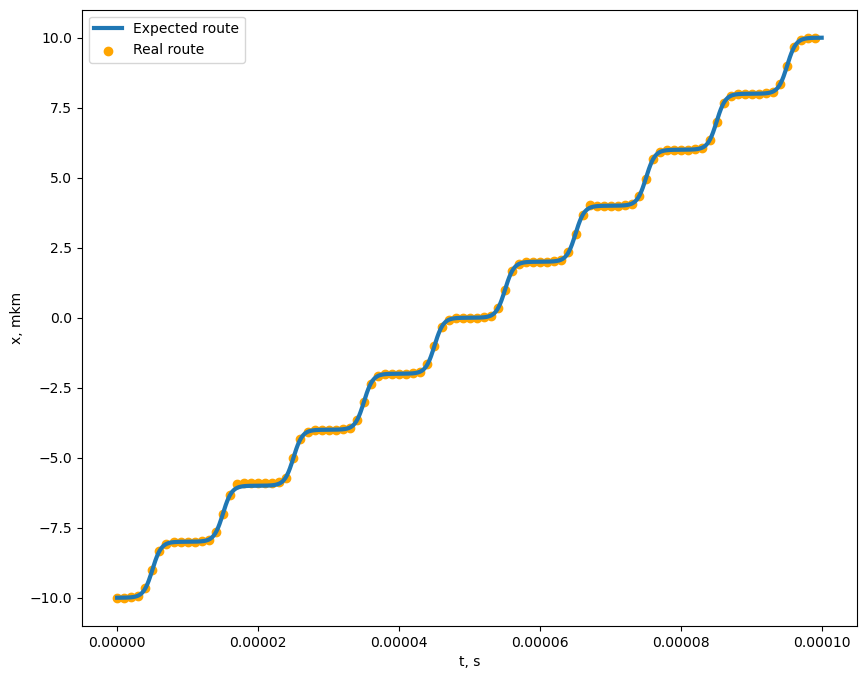

In [8]:
# we wish to obtain the following function of x(t)

# let's calculate real positions of potential minimum at each time step 
x_sim = []
x_theor = []
x_start = x0 - np.array([10, 0, 0]) 
x_min = []
for i in range(10):
    x_min.append(x_start + np.array([i*d, 0, 0]))
x_min = np.array(x_min)
for delt in range(10):
    for dt in range(res):
        def q_tan(t, d, T, a = 0, N = 4):
            return d/2*(np.tanh(N*(2*t-T)/T)/np.tanh(N) + 1) + a*x_min[delt][0] 
        t = dt*T/(res)
        x = x_min[delt] + np.array([q_tan(t, d, T), 0, 1e-9])
        xx.append(x[0])
        u_set = [0]
        u_set.extend(all_sequences[delt][dt])
        with s.with_voltages(dcs = u_set, rfs = None):
            x1 = s.minimum(x, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
            x_sim.append(x1[0])

    x_theor.extend(q_tan(np.arange(100)*T/100, d, T, a = 1))
        
fig = plt.figure(figsize = [10,8])
plt.plot(np.arange(1000)*T/100, x_theor,linewidth = 3, label = 'Expected route')
plt.scatter(np.arange(100)*T/10, x_sim, linewidth = 1, color = 'orange', label = 'Real route')

plt.xlabel('t, s')
plt.ylabel('x, mkm')

plt.legend()

plt.show()

 # Arbitrary shuttling

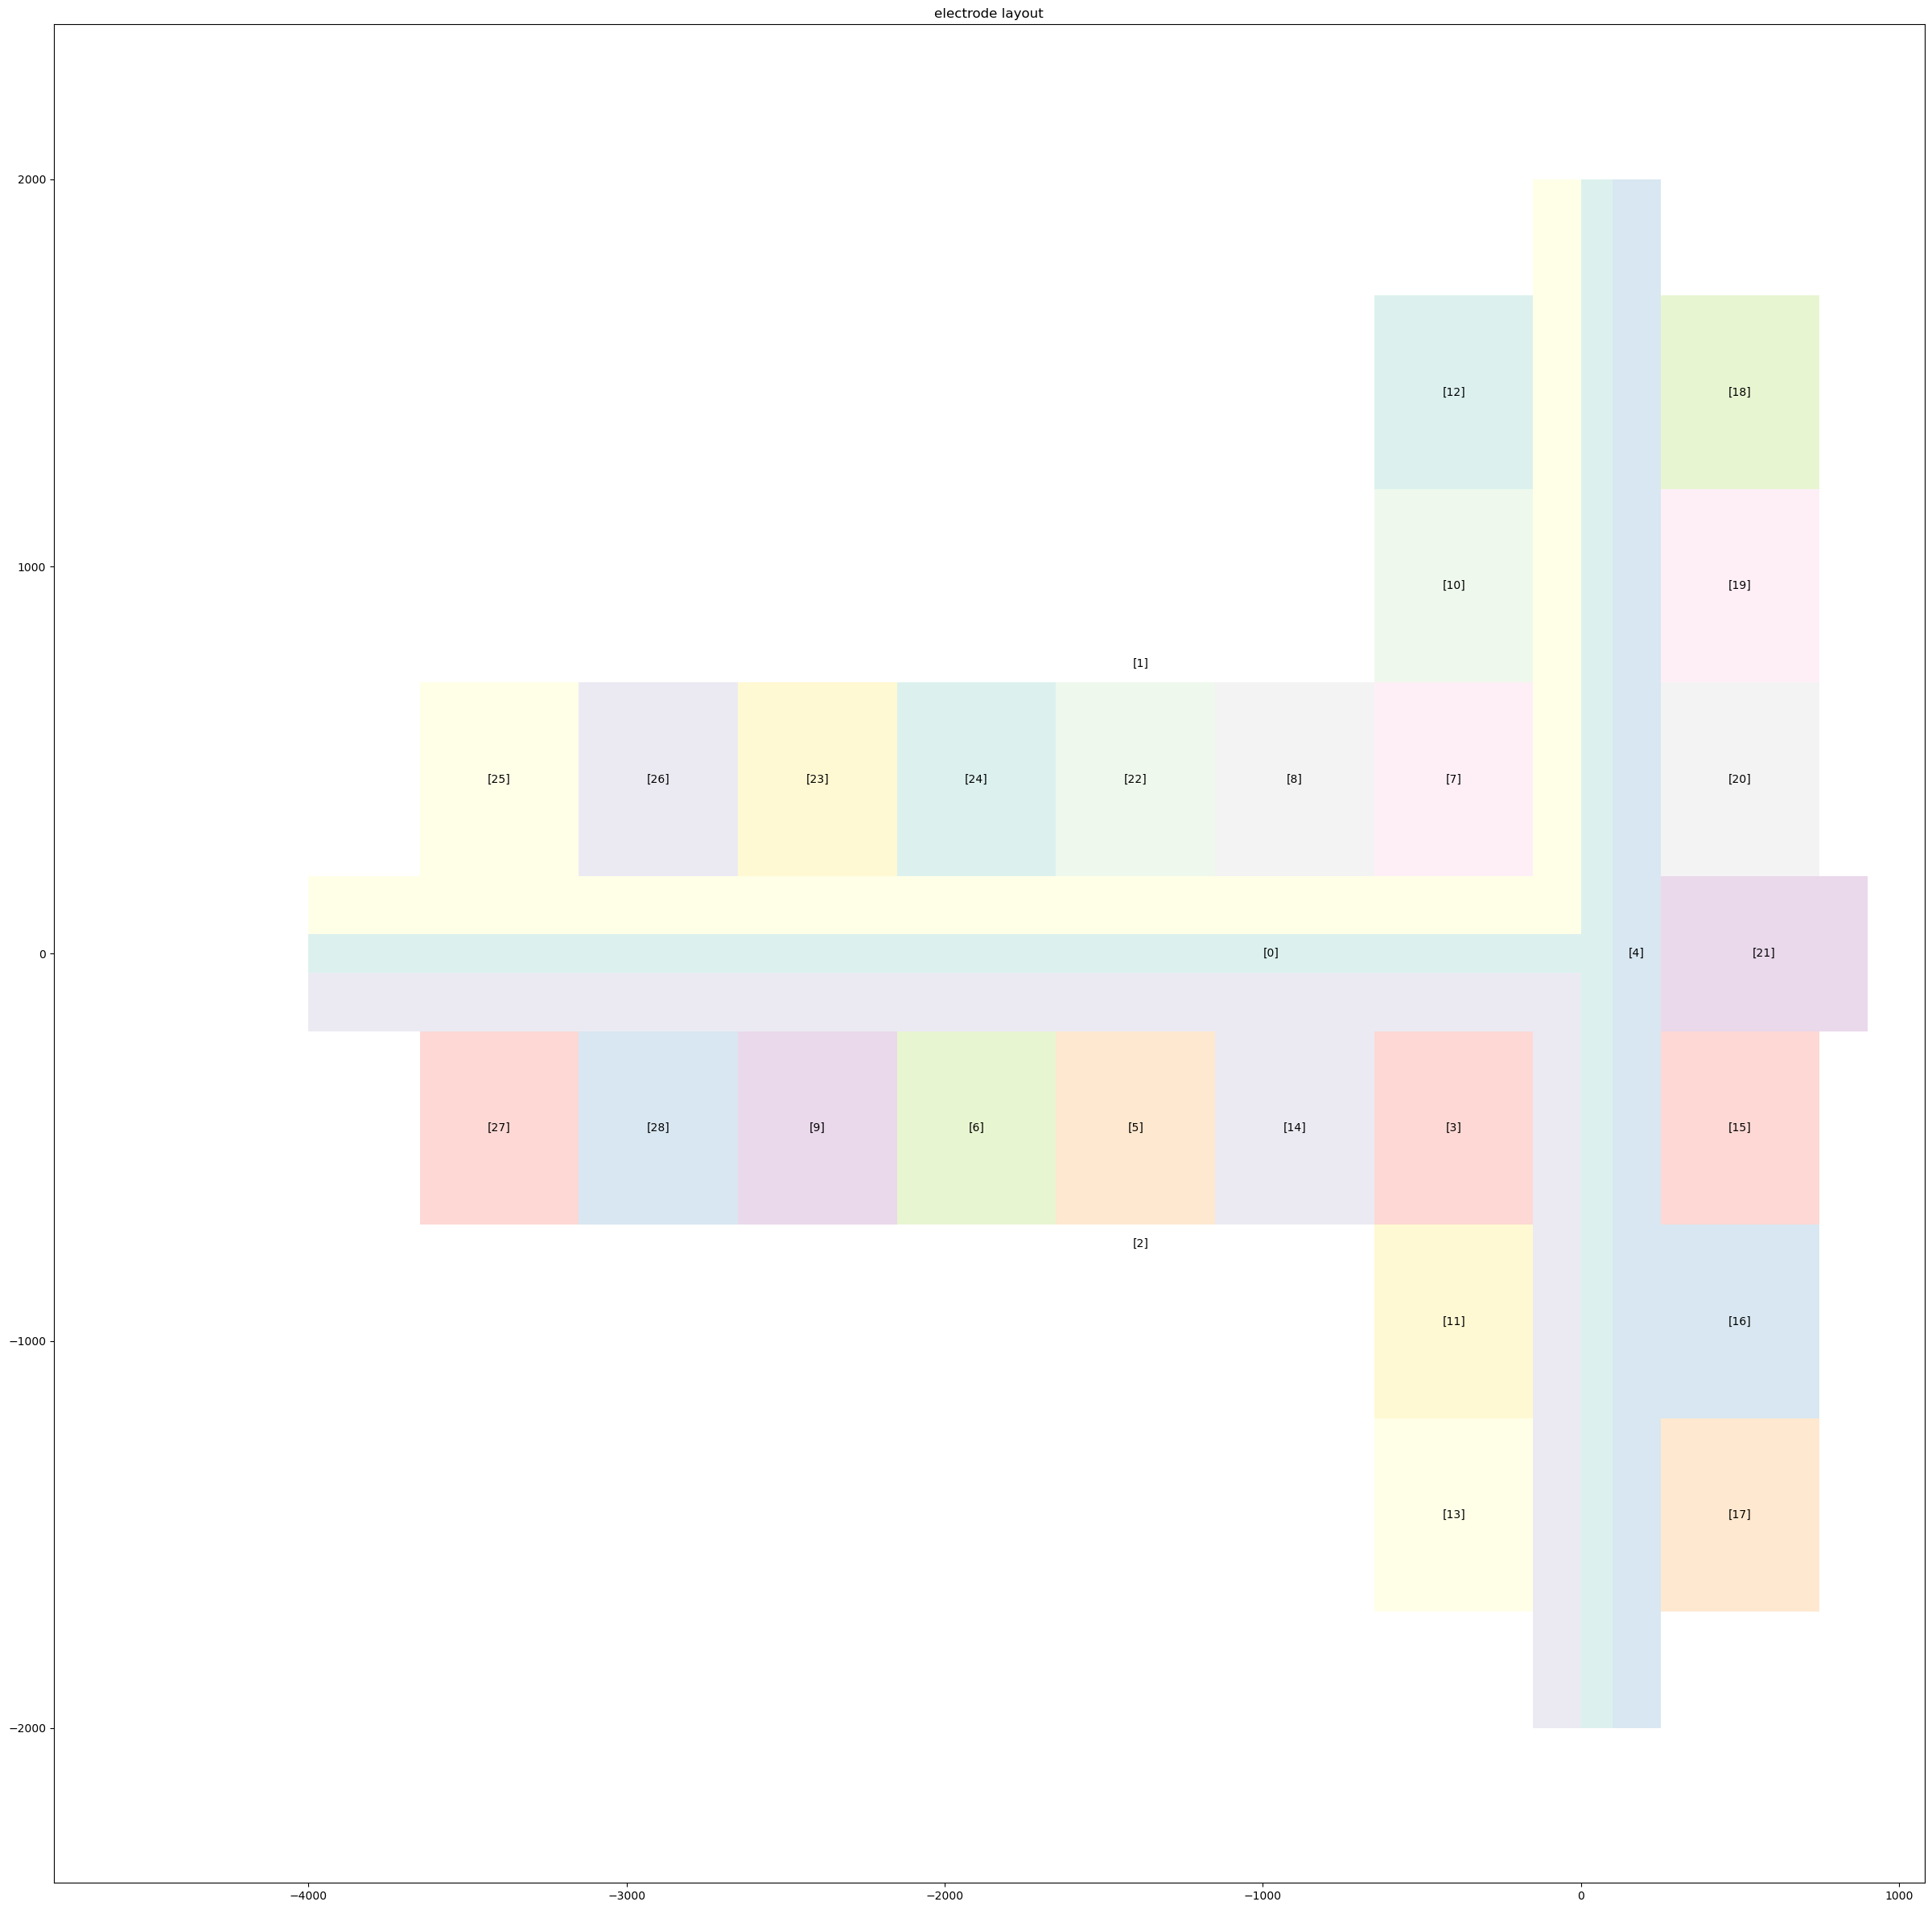

In [12]:
L = 1e-6 # µm length scale
s, full_electrode_list = sn.polygons_from_gds('t_junction.GDS', need_plot = True, need_coordinates = True, L=L)

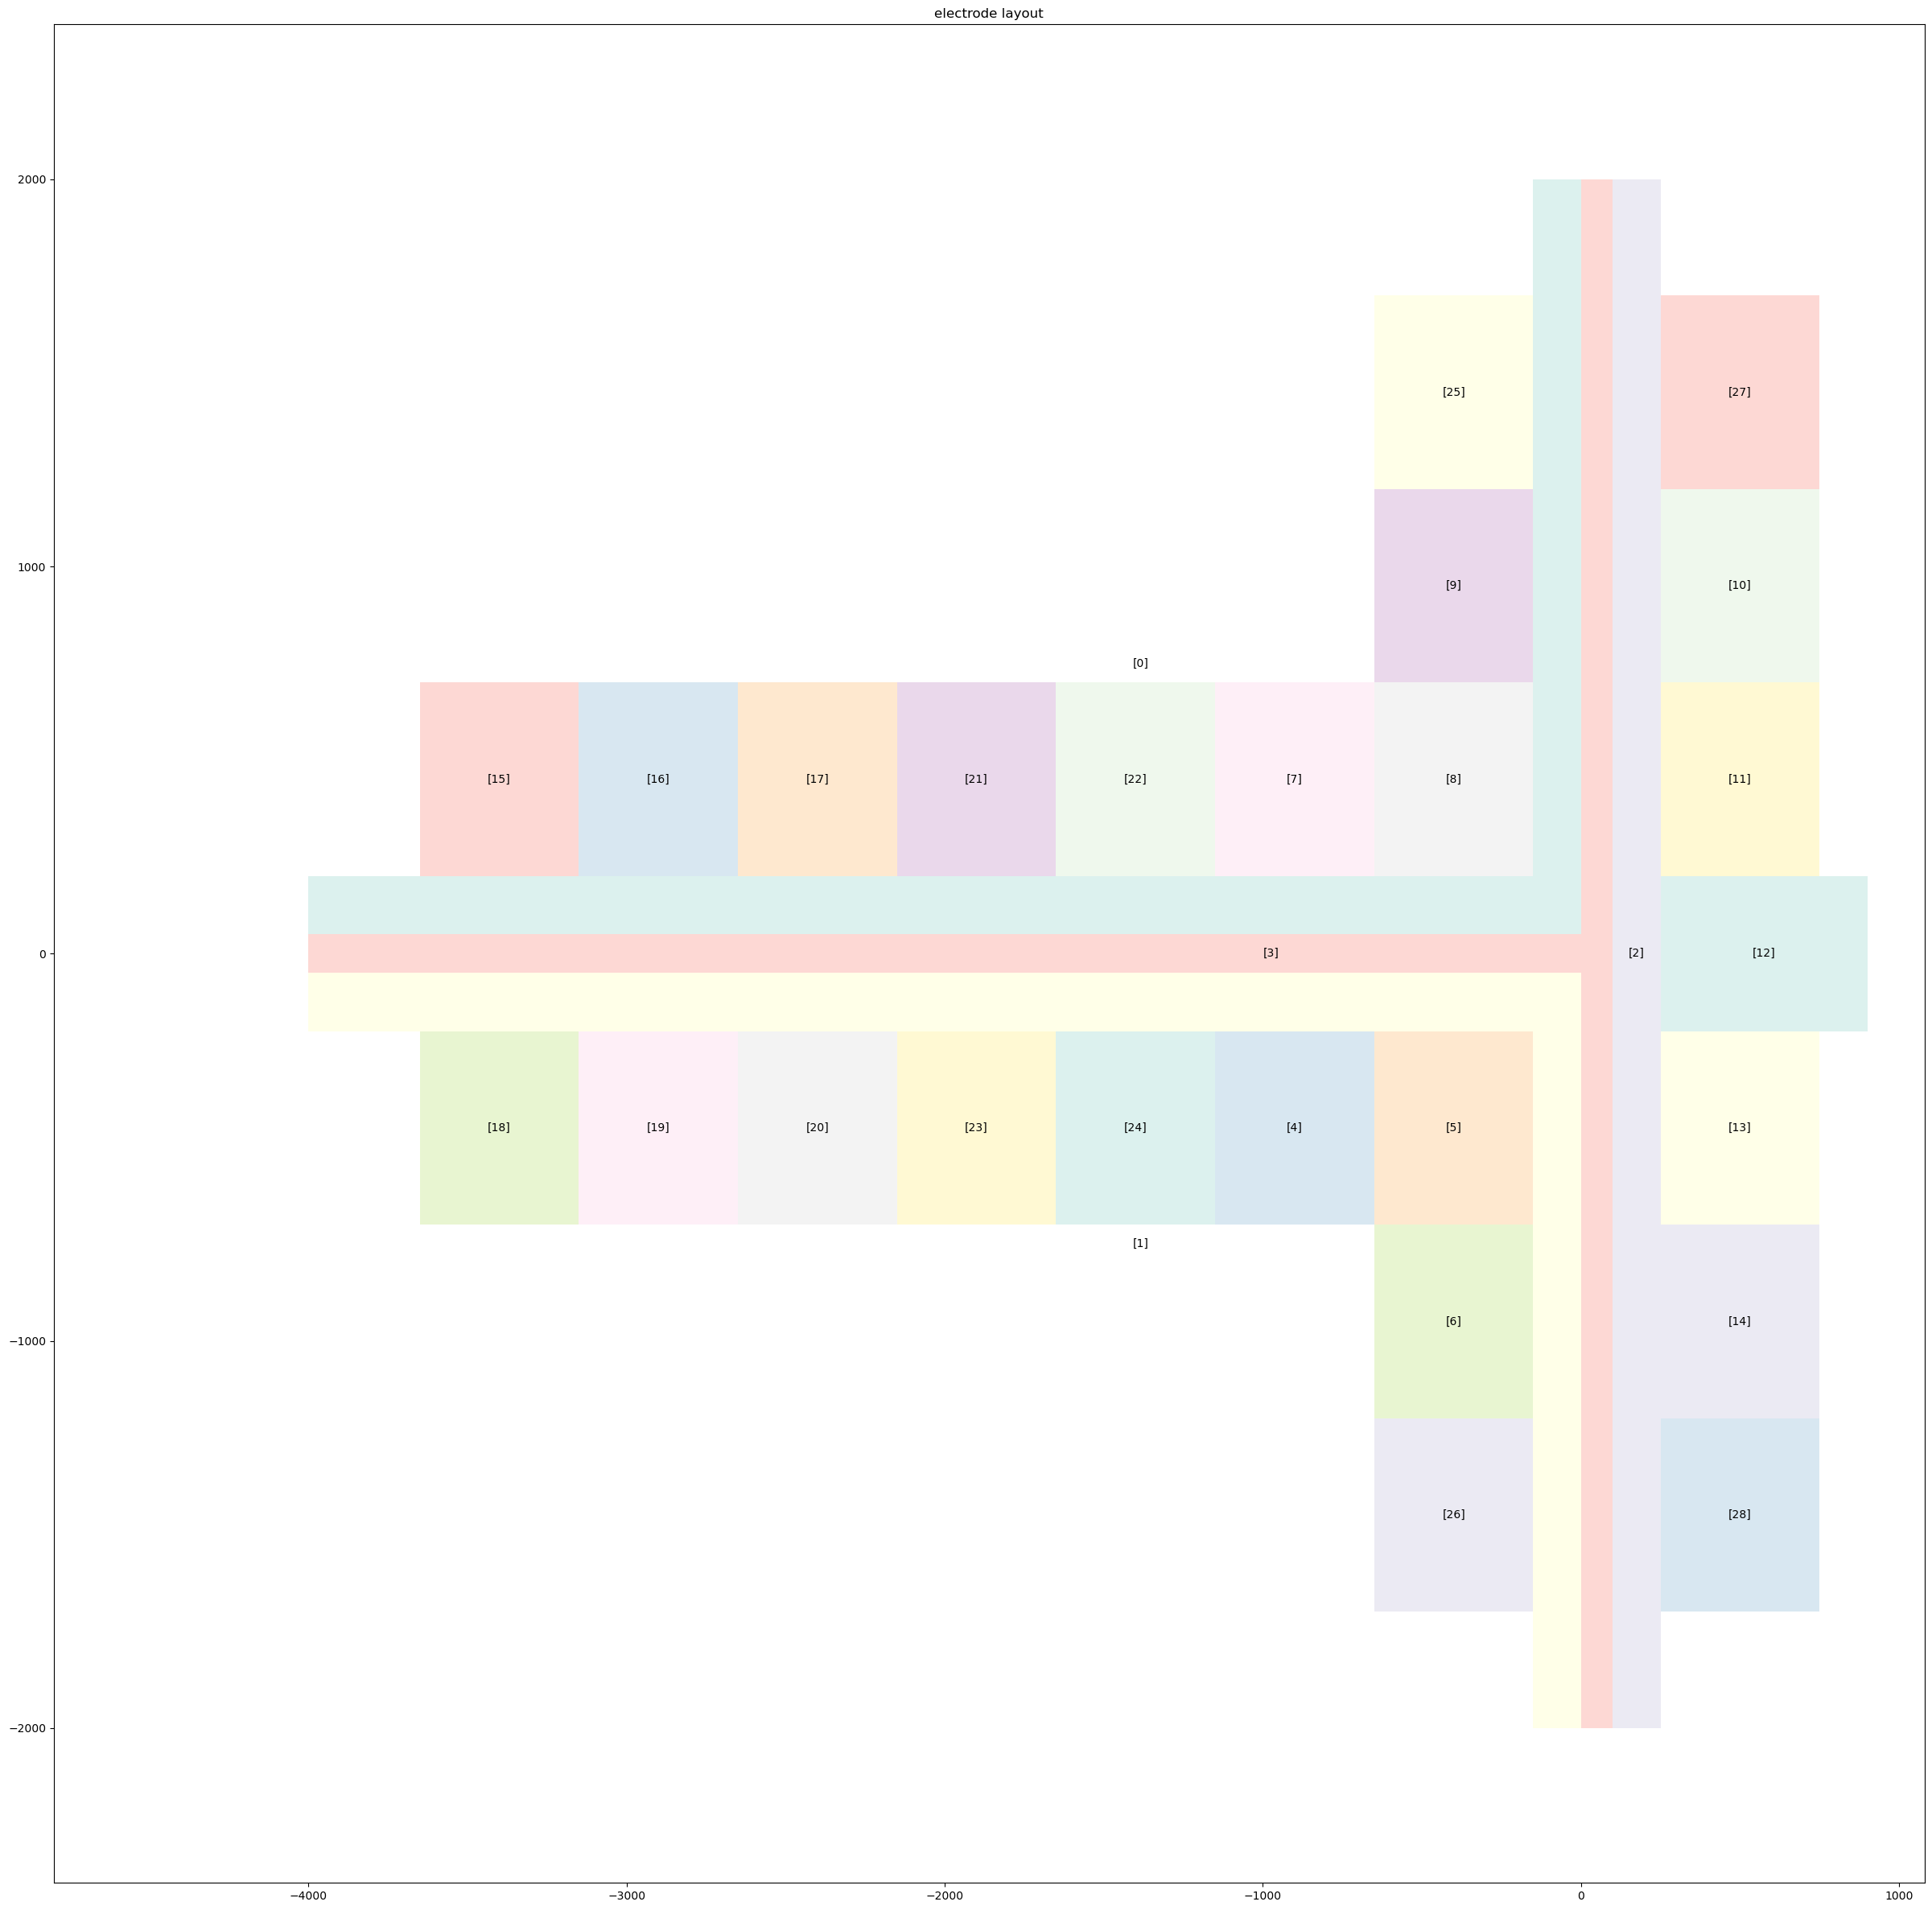

In [13]:
order = [1,2,4, 0, 14,3,11, 8,7,10, 19,20,21,15,16,  25,26,23,27,28,9, 24,22,6,5, 12,13,18,17]
s, full_electrode_list = sn.polygons_reshape(full_electrode_list, order)

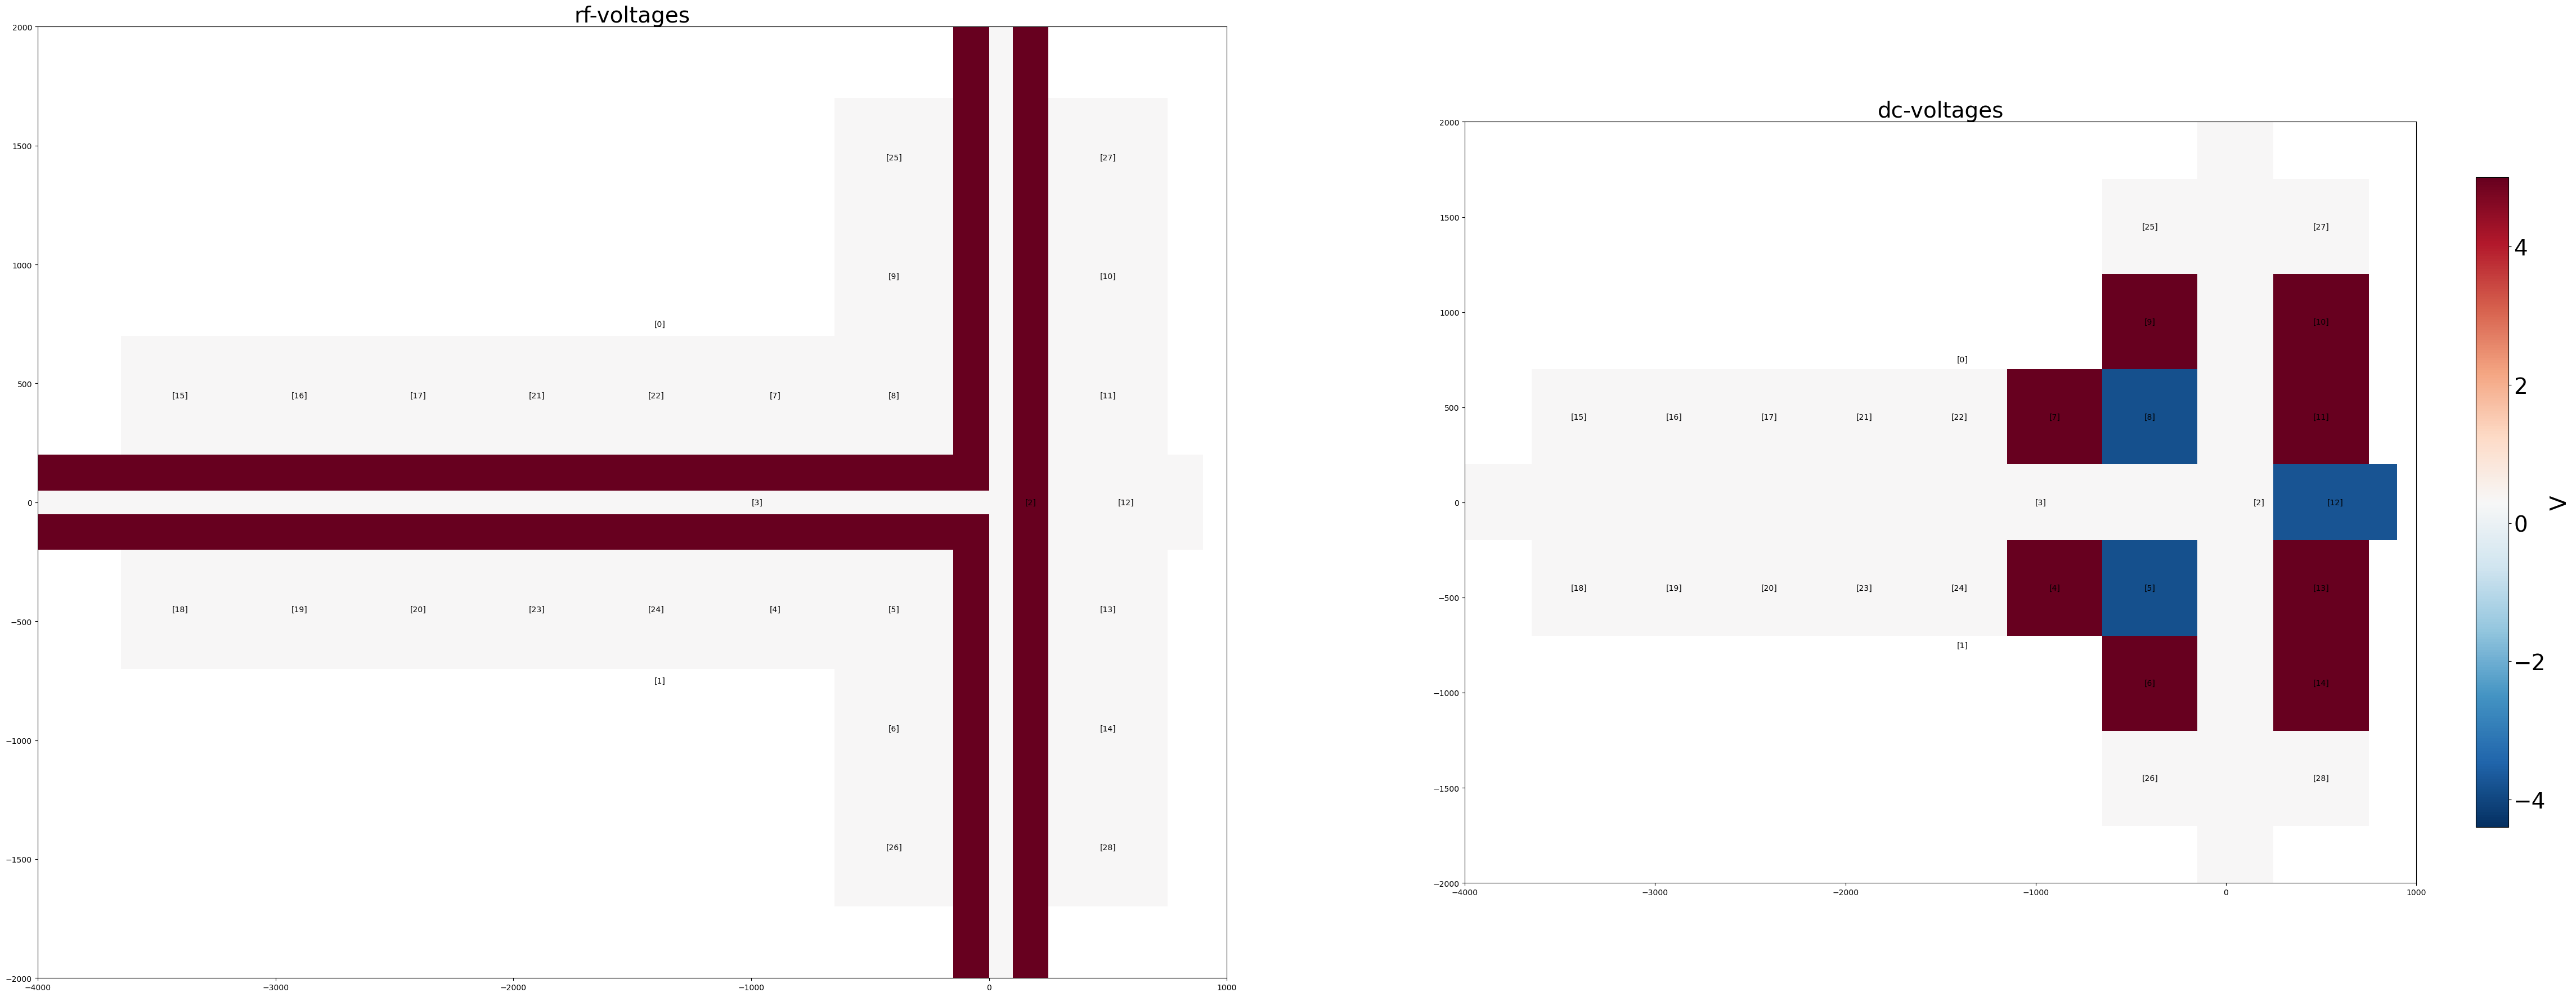

In [14]:
Vrf = 150. # RF peak voltage in V
M = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*30e6 # RF frequency in rad/s
# RF voltage in parametrized form so that the resulting potential equals the RF pseudopotential in eV
Urf = Vrf*np.sqrt(Z/M)/(2*L*Omega)

RF_electrodes = full_electrode_list[:3]
DC_electrodes = full_electrode_list[3:]

s.rfs = np.array([Urf, Urf, Urf])
rf_set = [Vrf, Vrf, Vrf]
dc_set = np.zeros(28)
dc_set[1:12] = 5*np.array([1,-0.88,1,1,-0.88,1,1,1,-0.86,1,1])
u_set = np.concatenate((np.zeros(3), dc_set))

omegas = [Omega, Omega, Omega]
with s.with_voltages(dcs = u_set, rfs = None):
    fig, ax = plt.subplots(1, 2, figsize=(60, 30))
    s.plot_voltages(ax[0], u=s.rfs)
    s.plot_voltages(ax[1], u=s.dcs)
    ax[0].set_title("rf-voltages", fontsize = 28)
    # ax[0] addresses the first plot in the subplots - set_title gives this plot a title
    ax[1].set_title("dc-voltages", fontsize = 28)
    for axi in ax.flat:
        axi.set_aspect("equal")
        axi.set_xlim(-4000, 1000)
        axi.set_ylim(-2000, 2000)
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=np.min(s.dcs), vmax=np.max(s.dcs))

    cb = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap=cmap),ax=axi,orientation = 'vertical', shrink =0.5, pad = 0.05)

    cb.ax.tick_params(labelsize=28)
    cb.set_label('V', fontsize = 28)

In [15]:
x1 = np.array(s.minimum((0., 2, 3), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))

with s.with_voltages(dcs = u_set, rfs = None):
    x0 = np.array(s.minimum(x1*1.0001, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
    print(f'Distance from RF minimum: {np.round(x0-x1, 3)} um')
    curv_z, mod_dir=s.modes(x0 ,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("in directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    #print(sn.anharmonics(sist, [x1], 0, L))

Distance from RF minimum: [-0.255  0.    -0.041] um
secular frequencies: (1.33, 1.86, 3.458) MHz
in directions
a: [ 1.04764960e-05 -9.91185166e-01 -1.32483833e-01] 
b: [-1.00000000e+00 -1.06612666e-05  6.85316338e-07] 
c: [-2.09172086e-06  1.32483833e-01 -9.91185166e-01]


In [7]:
T = 1e-4
d = 2

x_start = x1-np.array([d,0,0])
N = 3
res = 100

def route(t):
    if t<=T/2:
        return np.array([d/2*(np.tanh(N*(2*t-T*0.5)/(T*0.5))/np.tanh(N) + 1), 0, 0]) 
    else:
        return np.array([d, d/2*(np.tanh(N*(2*(t-T*0.5)-T*0.5)/(T*0.5))/np.tanh(N) + 1), 0]) 

shuttlers = range(12) #with central [0] electrode excluded

start_time = time.time()
voltage_sequence = sn.shuttling_voltage(s, x_start, route, T, dc_set, shuttlers = shuttlers, res = res, need_func = False)
print("Optimization took:", np.round(time.time()-start_time), "seconds")

Optimization took: 424.0 seconds


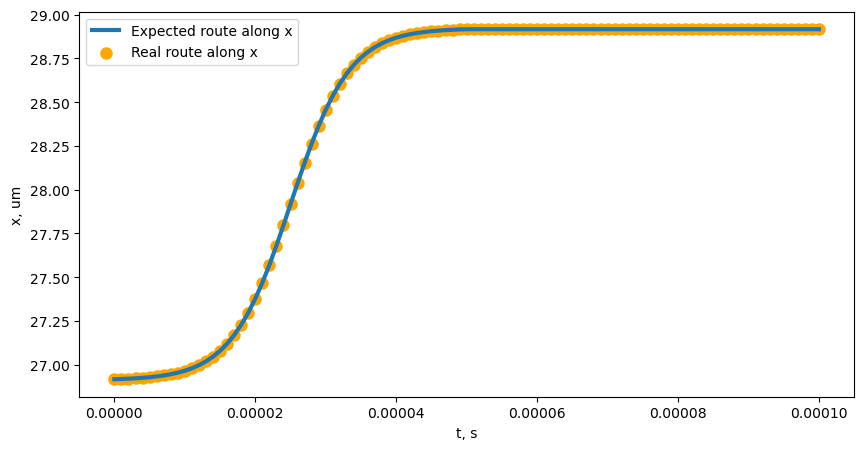

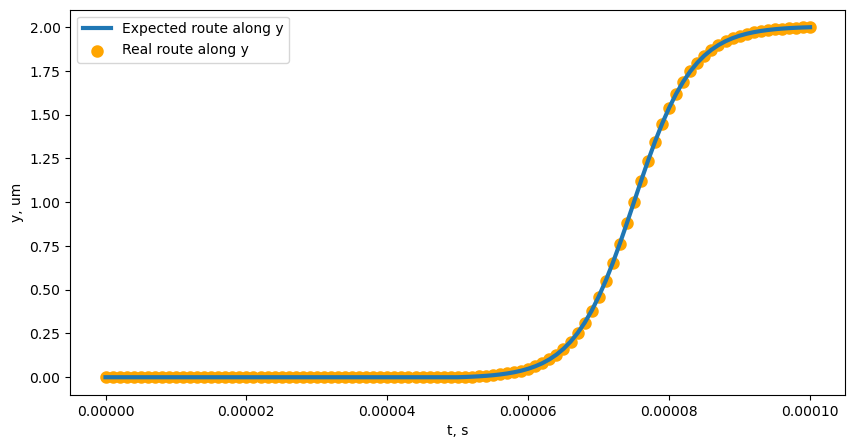

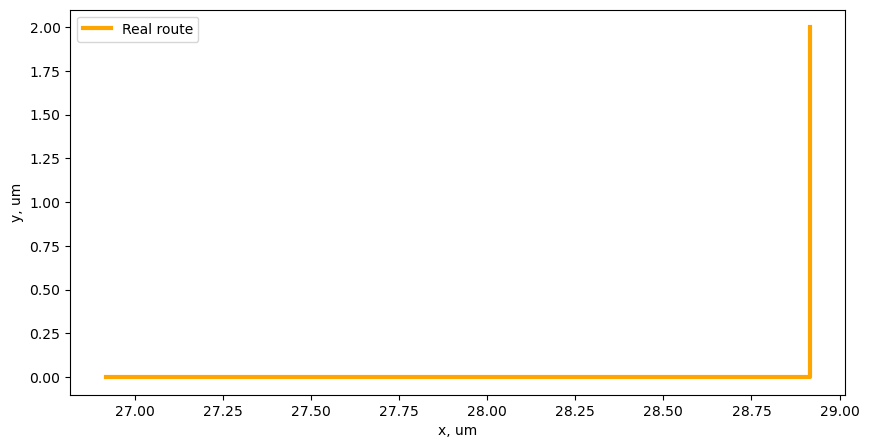

In [8]:
volt_seq = voltage_sequence.T
xx = []
yy = []
omegas = []
omegas_y = []
omegas_z = []

x_theor = []
y_theor = []

for dt in range(101):
    t = dt*T/100
    x_theor.append(x_start[0] + route(t)[0])
    y_theor.append(x_start[1] + route(t)[1])

for dt in range(res+1):
    t = dt*T/res
    x = x_start + route(t)
    u_set = np.concatenate((np.zeros(3), volt_seq[dt]))
    with s.with_voltages(dcs = u_set, rfs = None):
        x1 = s.minimum(x, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
        xx.append(x1[0])
        yy.append(x1[1])
        curv_z, mod_dir=s.modes(x1,sorted=False)
        omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
        omegas.append(omega_sec[0])
        omegas_y.append(omega_sec[1])
        omegas_z.append(omega_sec[2])
        
fig = plt.figure(figsize = [10,5])
plt.plot(np.arange(101)*T/100, x_theor ,linewidth = 3, label = 'Expected route along x')
plt.scatter(np.arange(res+1)*T/res, xx,linewidth = 3, color = 'orange', label = 'Real route along x')

plt.xlabel('t, s')
plt.ylabel('x, um')
plt.legend()

plt.show()

fig = plt.figure(figsize = [10,5])
plt.plot(np.arange(101)*T/100, y_theor,linewidth = 3, label = 'Expected route along y')
plt.scatter(np.arange(res+1)*T/res, yy,linewidth = 3, color = 'orange', label = 'Real route along y')

plt.xlabel('t, s')
plt.ylabel('y, um')
plt.legend()

plt.show()

fig = plt.figure(figsize = [10,5])
#plt.plot(np.arange(101)*T/100, q_tan(np.arange(101)*T/100, d, T, a = 1) ,linewidth = 3, label = 'Expected route')
plt.plot(xx, yy,linewidth = 3, color = 'orange', label = 'Real route')

plt.xlabel('x, um')
plt.ylabel('y, um')
plt.legend()

plt.show()

In [10]:
funcs = sn.approx_linear_shuttling(voltage_sequence, T, dc_set, shuttlers, res=res)

for i, func in enumerate(funcs):
    print(f'{i}th electrode:', func)
    


SystemExit: Failed to fit 1th electrode. Needs custom curve fitting

#### We need custom fit for 8th and 10th electrode's voltage sequences.

In [ ]:
def double_tan(t, a, b, c, d, e, f, g):
    return a*np.tanh(b*(t + c)) + d + e*np.tanh(f*(t + g))

def tan(t, a, b, c, d):
    return a*np.tanh(b*(t + c)) + d

funcs = ['0' for i in range(len(DC_electrodes))]

custom = [0,1,2,3,4,5,6,7,8,9,10,11]
for el in custom:
    dif1 = (voltage_sequence[el][int(0.5*res)]-voltage_sequence[el][0])/2
    dif2 = (voltage_sequence[el][-1]-voltage_sequence[el][int(0.5*res)] )/2

    if el != 7 and el != 9 and el != 11:
        p0 = [np.abs(dif1), 1/T/0.1, -0.25*T, dif1+dif2, np.abs(dif2), 1/T/0.1, -0.75*T]
        if el == 2 or el == 5 or el == 8 or el == 10:
            p0 = [np.abs(dif1), 13e4, -0.25*T, dif1+dif2, np.abs(dif2), 13e4, -0.75*T]
        if el == 3 or el == 6:
            p0 = [np.abs(dif1), 5e5, -0.25*T, dif1+dif2, np.abs(dif2), 5e5, -0.75*T]
        if el == 1 or el == 4:
            p0 = [np.abs(dif1), 2e5, -0.25*T, (voltage_sequence[el][-1]+voltage_sequence[el][0] )/2, np.abs(dif2), 2e5, -0.75*T]
        popt_, pcov = scipy.optimize.curve_fit(double_tan, np.arange(res+1)*T/res, voltage_sequence[el], p0, maxfev = 100000)
        funcs[el] = '((%5.6f) * (1 - 2/(exp(2*((%5.6f) * (step*dt + (%5.6f)))) + 1)) + (%5.6f) + (%5.6f) * (1 - 2/(exp(2*((%5.6f) * (step*dt + (%5.6f)))) + 1)))' % tuple(popt_)
    else: 
        dif = (voltage_sequence[el][-1]-voltage_sequence[el][0])/2
        if el == 9:
            p0 = [np.abs(dif), 10e4, -0.8*T, dif]
        if el == 7:
            p0 = [np.abs(dif), 5e5, -0.8*T, dif]
        if el == 11:
            p0 = [np.abs(dif), 5e5, -0.8*T, dif]
        popt_tan, pcov = scipy.optimize.curve_fit(tan, np.arange(res+1)*T/res, voltage_sequence[el], p0, maxfev = 100000)
        funcs[el] = '((%5.6f) * (1 - 2/(exp(2*((%5.6f) * (step*dt + (%5.6f)))) + 1)) + (%5.6f))' % tuple(popt_tan)
        
    
funcs[0] = '0.093178'
for i, func in enumerate(funcs):
    print(f'{i}th electrode:', func)

In [ ]:
def ppp(t,k):
    return eval((funcs[k].replace('step*dt', 't')).replace('^', '**'))

for k, seq in enumerate(voltage_sequence[:12]):
    if k != 0:
        fig = plt.figure(figsize = (4, 1))
        plt.title(f'{k}th electrode')
        plt.plot(np.arange(res+1)*T/res, seq)
        plt.plot(np.arange(res+1)*T/res, ppp(np.arange(res+1)*T/res, k))
        plt.show()

In [12]:
shuttles = []
for i, func in enumerate(funcs):
    shuttles.append(func)

positions = np.array(sn.ioncloud_min(x_start, 1, 0))*L

name = Path('shuttling.ipynb').stem

sim = pl.Simulation(name)
#
Caions = {'mass': 40, 'charge': 1}


rf_set = [Vrf, Vrf, Vrf]
Omegas = [Omega for i in range(3)]

sim.append(pl.placeions(Caions, positions))

sim.append(sn.polygon_shuttling(Omegas, rf_set, RF_electrodes, DC_electrodes, shuttles))

sim.append(pl.langevinbath(0, 5e-6))

sim.append(pl.dump('poslinshuttle2d.txt', variables=['x', 'y', 'z'], steps=10))

t_evolve = int(T*20*Omega)

sim.append(pl.evolve(t_evolve))

try:
    sim.execute()
except:
    pass

Reducing timestep to 2.652582384864922e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Setting atom values ...
  1 settings made for charge
1 atoms in group 1
1 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 2.65258e-10
Per MPI rank memory allocation (min/avg/max) = 1.405 | 1.405 | 1.405 Mbytes
Step CPU 
       0            0 
   10000    85.32057

C:\Users\User_A\anaconda3\lib\site-packages\pylion-0.5.2-py3.9.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


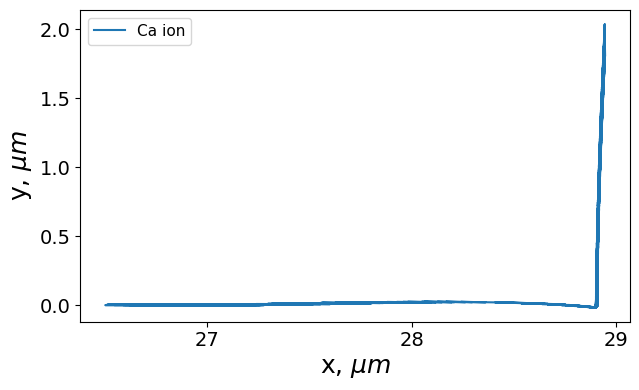

In [13]:
_, data = pl.readdump('poslinshuttle2d.txt')
data *=1e6

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

#plotting routine
fig, ax = plt.subplots(1,1,figsize = [6.5, 4] )
ax.plot(data[:, 0, 0], data[:, 0, 1], label = 'Ca ion')
plt.locator_params(axis='x', nbins=5)
ax.legend(prop = {'size': 11}, ncol = 2)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_ylabel('y, $\mu m$', fontsize = 18)
ax.set_xlabel('x, $\mu m$', fontsize = 18)
plt.tight_layout()
plt.show()

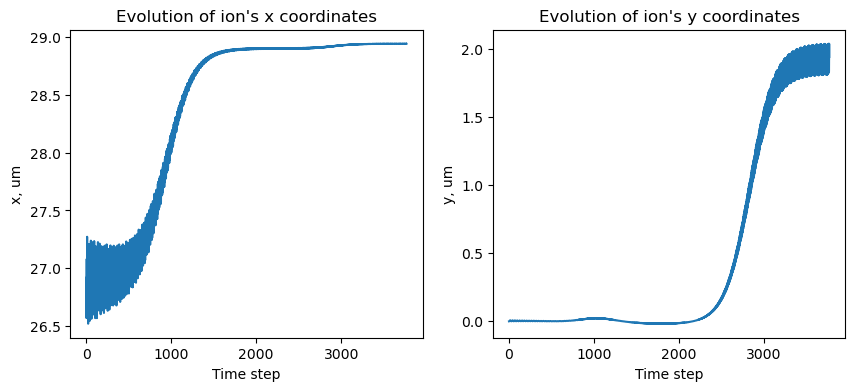

In [18]:
fig, ax = plt.subplots(1,2,figsize = (10,4))
for n in range(2):
    ax[n].plot(data[::10, 0, n])
    ax[n].set_xlabel('Time step')

ax[0].set_ylabel('x, um')
ax[0].set_title('Evolution of ion\'s x coordinates')
ax[1].set_ylabel('y, um')
ax[1].set_title('Evolution of ion\'s y coordinates')
plt.show()

# Parallel shuttling

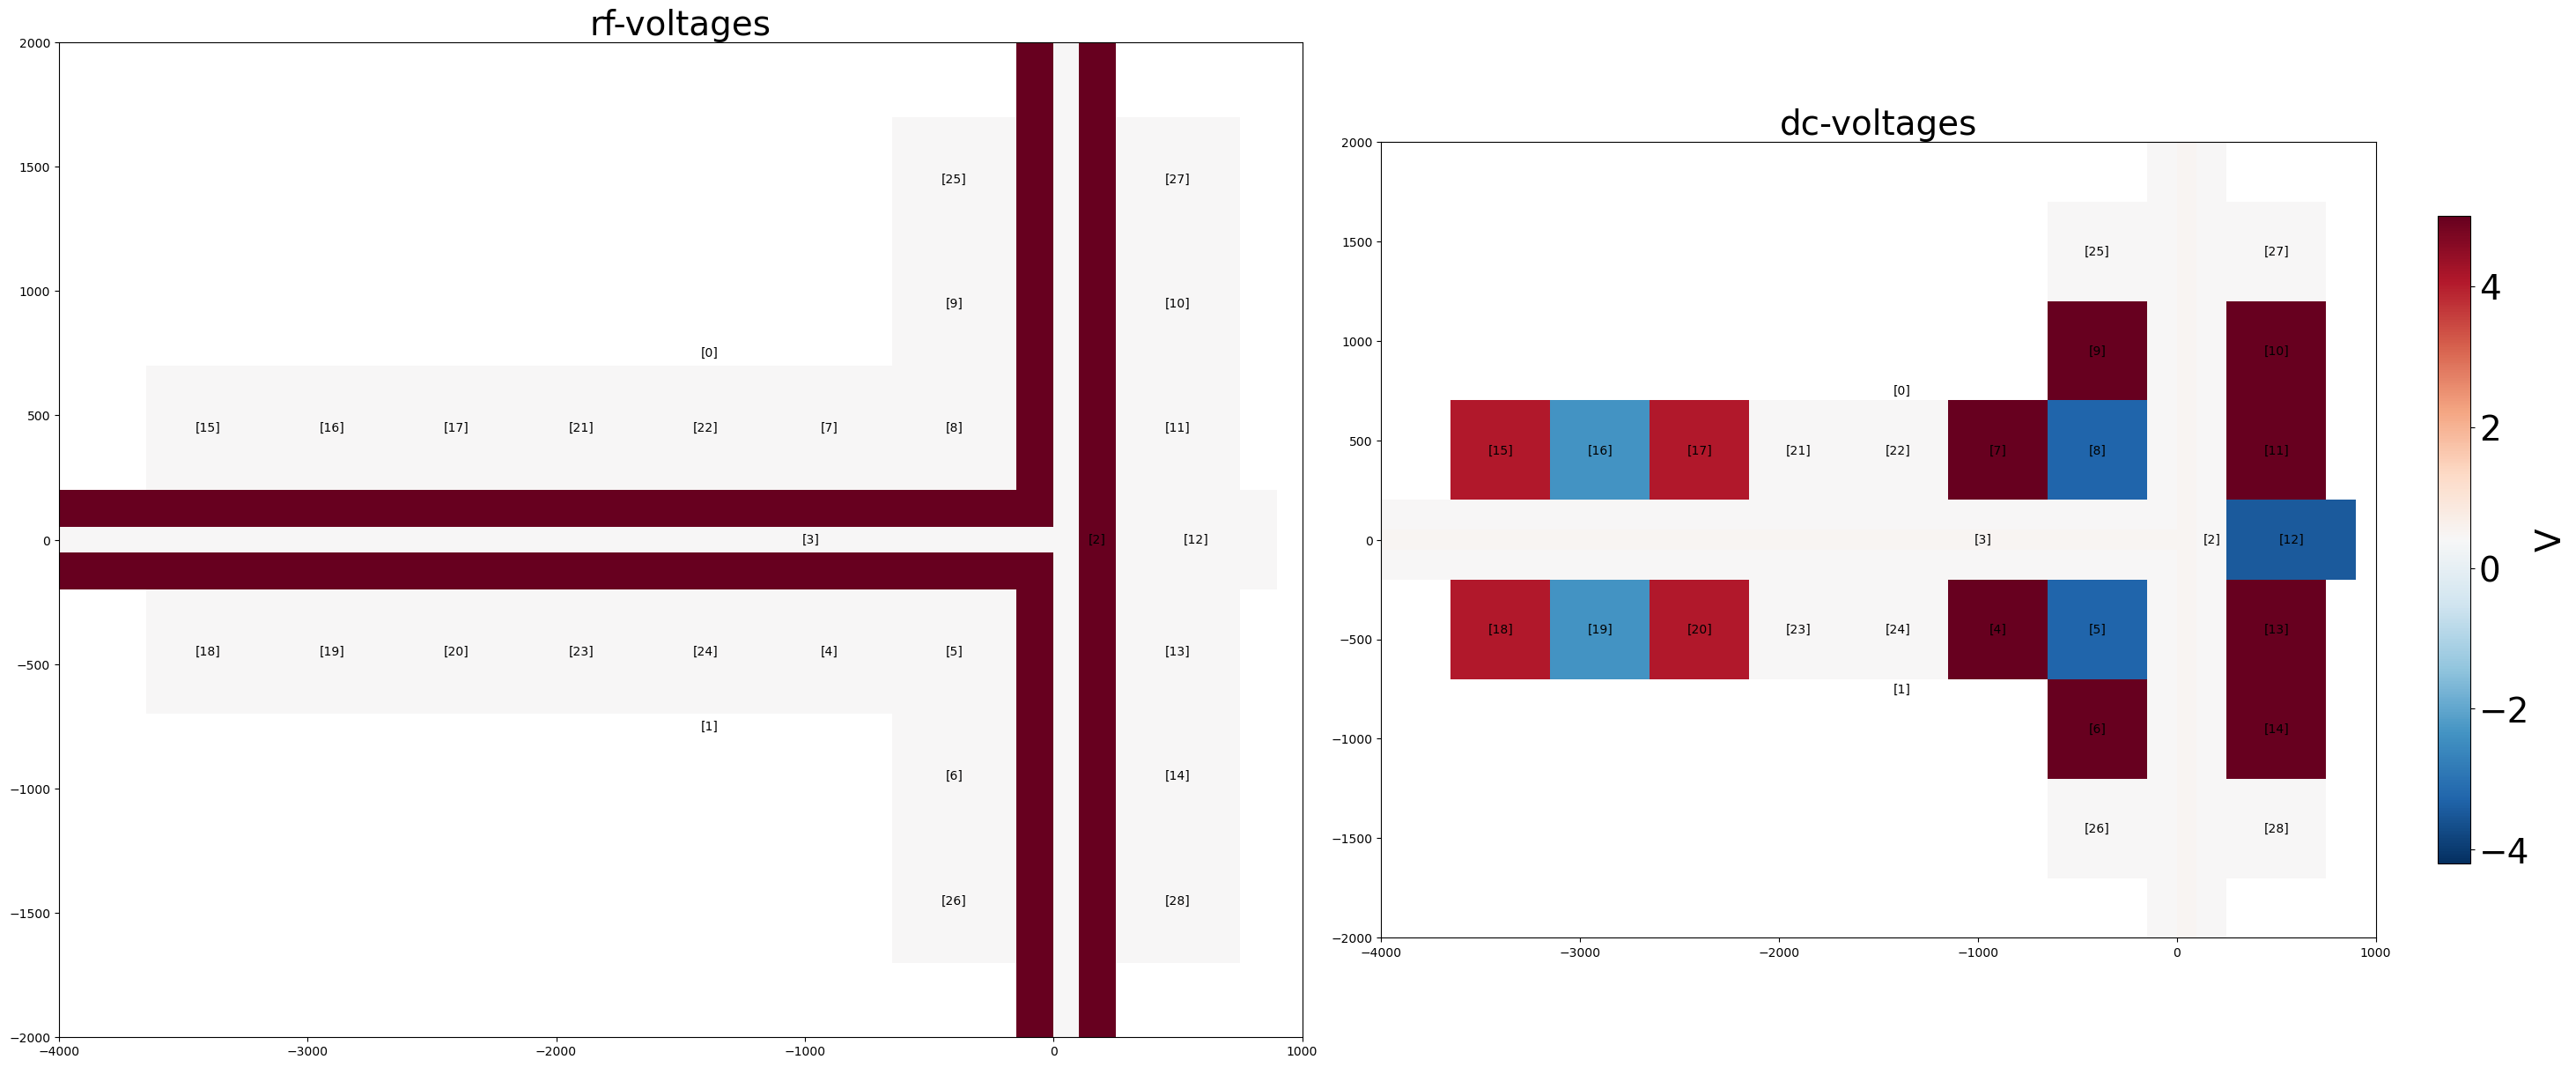

In [63]:
Vrf = 150. # RF peak voltage in V
M = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*30e6 # RF frequency in rad/s
# RF voltage in parametrized form so that the resulting potential equals the RF pseudopotential in eV
Urf = Vrf*np.sqrt(Z/M)/(2*L*Omega)

RF_electrodes = full_electrode_list[:3]
DC_electrodes = full_electrode_list[3:]

s.rfs = np.array([Urf, Urf, Urf])
rf_set = [Vrf, Vrf, Vrf]
dc_set = np.zeros(28)
dc_set[0:12] = 5*np.array([0.093/5, 1,-0.8,1,1,-0.8,1,1,1,-0.84,1,1])
dc_set[12:18] = np.array([4,-3,4,4,-3,4])
u_set = np.concatenate((np.zeros(3), dc_set))

omegas = [Omega, Omega, Omega]
with s.with_voltages(dcs = u_set, rfs = None):
    fig, ax = plt.subplots(1, 2, figsize=(30, 15))
    s.plot_voltages(ax[0], u=s.rfs)
    s.plot_voltages(ax[1], u=s.dcs)
    ax[0].set_title("rf-voltages", fontsize = 28)
    # ax[0] addresses the first plot in the subplots - set_title gives this plot a title
    ax[1].set_title("dc-voltages", fontsize = 28)
    for axi in ax.flat:
        axi.set_aspect("equal")
        axi.set_xlim(-4000, 1000)
        axi.set_ylim(-2000, 2000)
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=np.min(s.dcs), vmax=np.max(s.dcs))

    cb = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap=cmap),ax=axi,orientation = 'vertical', shrink =0.5, pad = 0.05)

    cb.ax.tick_params(labelsize=28)
    cb.set_label('V', fontsize = 28)
    plt.tight_layout()
    plt.savefig('images/junction_trap_voltage.eps')

In [27]:
x1 = np.array(s.minimum((0., 2, 3), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
x2 = np.array(s.minimum((-2900., 0, 100), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))

with s.with_voltages(dcs = u_set, rfs = None):
    x0 = np.array(s.minimum(x1*1.0001, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
    print(f'Junction minimum: {np.round(x0,2)} um')
    print(f'Distance from RF minimum: {np.round(x0-x1,2)} um')
    curv_z, mod_dir=s.modes(x0 ,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("in directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    #print(sn.anharmonics(sist, [x1], 0, L))
    
    xs = np.array(s.minimum(x2, axis=(0, 1, 2), coord=np.identity(3), method="L-BFGS-B"))
    print(f'Storage minimum: {np.round(xs,2)} um')
    print(f'Distance from RF minimum: {np.round(xs-x2,2)} um')
    curv_z, mod_dir=s.modes(xs ,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("in directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    #print(sn.anharmonics(sist, [x1], 0, L))

Junction minimum: [ 30.07  -0.   136.43] um
Distance from RF minimum: [ 1.15  0.   -0.14] um
secular frequencies: (1.292, 1.91, 3.472) MHz
in directions
a: [ 1.01079593e-05 -9.92188837e-01 -1.24744988e-01] 
b: [-1.00000000e+00 -1.03042745e-05  9.28508751e-07] 
c: [-2.20666261e-06  1.24744988e-01 -9.92188837e-01]
Storage minimum: [-2900.02     0.     100.11] um
Distance from RF minimum: [-0.02  0.    0.63] um
secular frequencies: (0.7055, 6.513, 6.609) MHz
in directions
a: [ 9.99999384e-01 -4.78769315e-17 -1.10998100e-03] 
b: [ 3.18627388e-17  1.00000000e+00 -1.43218940e-14] 
c: [1.10998100e-03 1.40998324e-14 9.99999384e-01]


C:\Users\User_A\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:565: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


In [18]:
T = 1e-4
d = 10
starts = np.array([x0 - np.array([d,0,0]), xs])

N = 3
res = 50

def routes(i, t):
    if i == 0:
        if t<=T/2:
            return np.array([d/2*(np.tanh(N*(2*t-T*0.5)/(T*0.5))/np.tanh(N) + 1), 0, 0]) 
        else:
            return np.array([d, d/2*(np.tanh(N*(2*(t-T*0.5)-T*0.5)/(T*0.5))/np.tanh(N) + 1), 0]) 
    if i == 1:
        return xs

shuttlers = range(16) #with central [0] electrode included

start_time = time.time()
voltage_sequence = sn.shuttling_voltage(s, starts, routes, T, dc_set, shuttlers = shuttlers, res = res, need_func = False)
print("Optimization took:", np.round(time.time()-start_time), "seconds")

Optimization took: 2174.0 seconds


0th electrode: 0.093178
1th electrode: ((0.032023) * (1 - 2/(exp(2*((121731.386953) * (step*dt + (-0.000026)))) + 1)) + (4.990207) + (0.023777) * (1 - 2/(exp(2*((121368.570236) * (step*dt + (-0.000075)))) + 1)))
2th electrode: ((0.204022) * (1 - 2/(exp(2*((123045.624745) * (step*dt + (-0.000026)))) + 1)) + (-3.839371) + (0.368769) * (1 - 2/(exp(2*((122036.890165) * (step*dt + (-0.000075)))) + 1)))
3th electrode: ((-0.018321) * (1 - 2/(exp(2*((-124330.720316) * (step*dt + (-0.000026)))) + 1)) + (5.027020) + (-0.048242) * (1 - 2/(exp(2*((-121986.360143) * (step*dt + (-0.000075)))) + 1)))
4th electrode: ((0.032256) * (1 - 2/(exp(2*((119885.989113) * (step*dt + (-0.000026)))) + 1)) + (4.942925) + (-0.023707) * (1 - 2/(exp(2*((123157.284958) * (step*dt + (-0.000075)))) + 1)))
5th electrode: ((0.207738) * (1 - 2/(exp(2*((118456.648865) * (step*dt + (-0.000026)))) + 1)) + (-4.595433) + (-0.389863) * (1 - 2/(exp(2*((122469.301981) * (step*dt + (-0.000075)))) + 1)))
6th electrode: ((0.018801) *

C:\Users\User_A\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


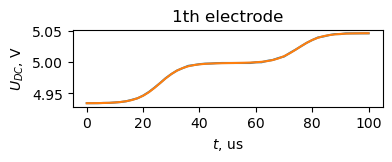

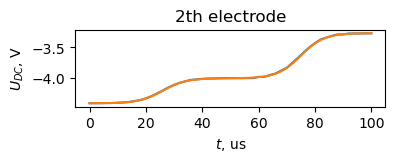

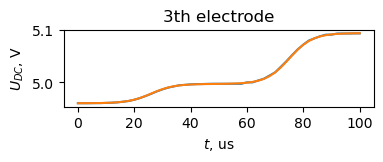

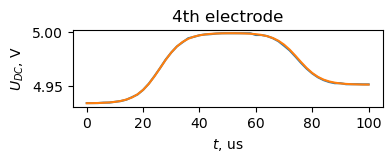

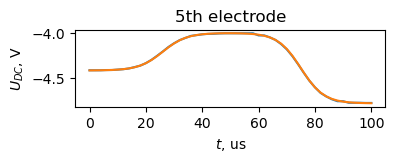

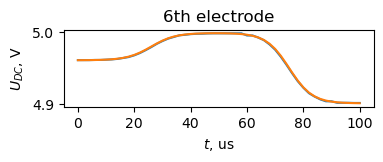

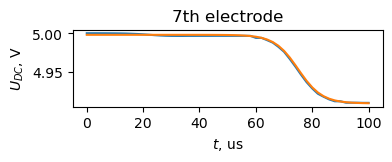

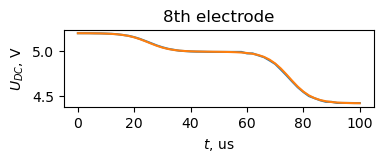

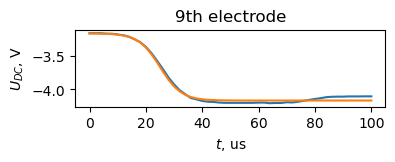

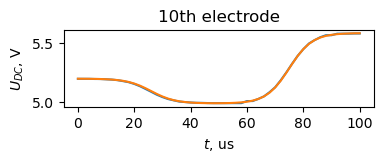

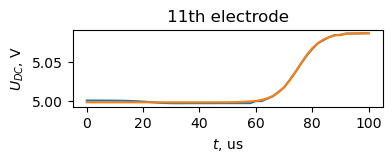

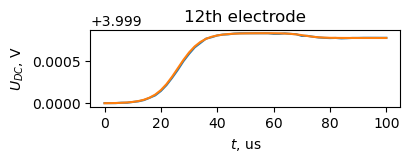

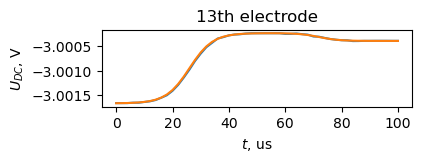

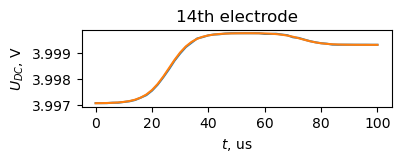

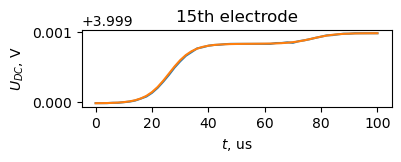

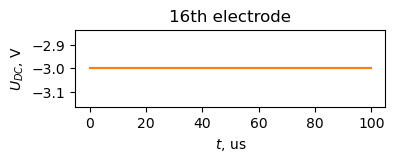

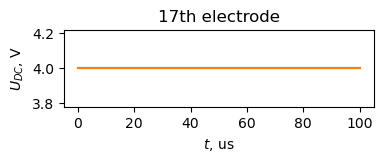

In [19]:
def double_tan(t, a, b, c, d, e, f, g):
    return a*np.tanh(b*(t + c)) + d + e*np.tanh(f*(t + g))

def tan(t, a, b, c, d):
    return a*np.tanh(b*(t + c)) + d

funcs = ['0' for i in range(len(DC_electrodes))]

custom = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
for el in custom:
    dif1 = (voltage_sequence[el][int(0.5*res)]-voltage_sequence[el][0])/2
    dif2 = (voltage_sequence[el][-1]-voltage_sequence[el][int(0.5*res)] )/2

    if el != 7 and el != 9 and el != 11:
        p0 = [np.abs(dif1), 1/T/0.1, -0.25*T, dif1+dif2, np.abs(dif2), 1/T/0.1, -0.75*T]
        if el == 2 or el == 5 or el == 8 or el == 10:
            p0 = [np.abs(dif1), 13e4, -0.25*T, dif1+dif2, np.abs(dif2), 13e4, -0.75*T]
        if el == 3 or el == 6:
            p0 = [np.abs(dif1), 5e5, -0.25*T, dif1+dif2, np.abs(dif2), 5e5, -0.75*T]
        if el == 1 or el == 4:
            p0 = [np.abs(dif1), 2e5, -0.25*T, (voltage_sequence[el][-1]+voltage_sequence[el][0] )/2, np.abs(dif2), 2e5, -0.75*T]
        if el == 12 or el == 13 or el == 14 or el == 15 or el == 16 or el == 17:
            p0 = [np.abs(dif1), 10e5, -0.25*T, (voltage_sequence[el][-1]+voltage_sequence[el][0] )/2, np.abs(dif2), 10e5, -0.75*T]
        popt_, pcov = scipy.optimize.curve_fit(double_tan, np.arange(res+1)*T/res, voltage_sequence[el], p0, maxfev = 100000)
        funcs[el] = '((%5.6f) * (1 - 2/(exp(2*((%5.6f) * (step*dt + (%5.6f)))) + 1)) + (%5.6f) + (%5.6f) * (1 - 2/(exp(2*((%5.6f) * (step*dt + (%5.6f)))) + 1)))' % tuple(popt_)
    
    else: 
        dif = (voltage_sequence[el][-1]-voltage_sequence[el][0])/2
        if el == 9:
            p0 = [np.abs(dif), 10e4, -0.8*T, dif]
        if el == 7:
            p0 = [np.abs(dif), 5e5, -0.8*T, dif]
        if el == 11:
            p0 = [np.abs(dif), 5e5, -0.8*T, dif]
        popt_tan, pcov = scipy.optimize.curve_fit(tan, np.arange(res+1)*T/res, voltage_sequence[el], p0, maxfev = 100000)
        funcs[el] = '((%5.6f) * (1 - 2/(exp(2*((%5.6f) * (step*dt + (%5.6f)))) + 1)) + (%5.6f))' % tuple(popt_tan)
        
    
funcs[0] = '0.093178'
for i, func in enumerate(funcs):
    print(f'{i}th electrode:', func)
    
    
def ppp(t,k):
    return eval((funcs[k].replace('step*dt', 't')).replace('^', '**'))

for k, seq in enumerate(voltage_sequence[:18]):
    if k != 0:
        fig = plt.figure(figsize = (4, 1))
        plt.title(f'{k}th electrode')
        plt.plot(np.arange(res+1)*T/res, seq)
        plt.plot(np.arange(res+1)*T/res, ppp(np.arange(res+1)*T/res, k))
        plt.ylabel('$U_{DC}$, V')
        plt.xlabel('$t$, us')
        plt.xticks([0, 20e-6, 40e-6, 60e-6, 80e-6, 100e-6], [0, 20, 40, 60, 80, 100])
        plt.tight_layout()
        plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


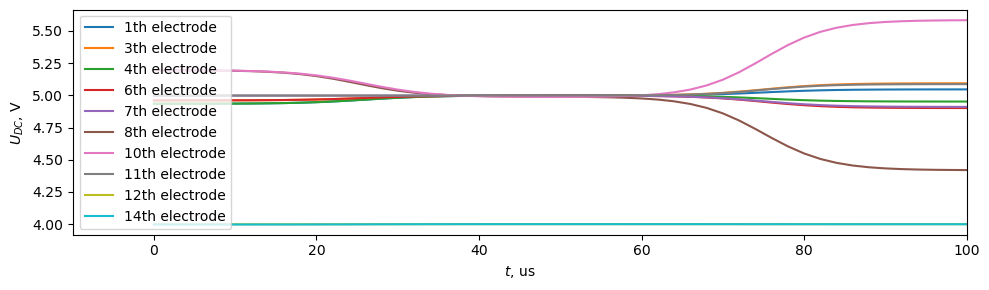

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


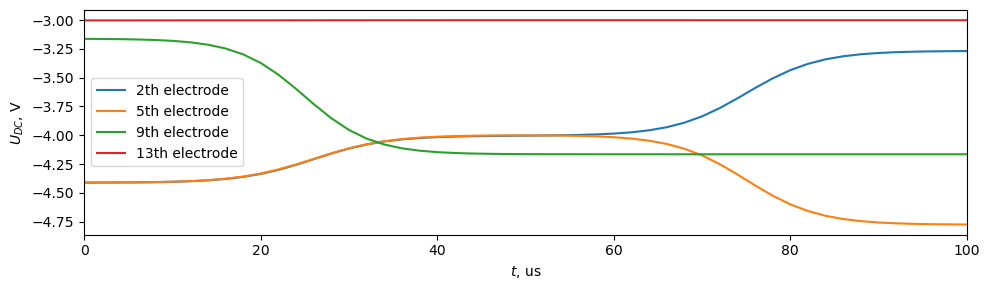

In [36]:
fig = plt.figure(figsize = (10, 3))
#plt.title(f'{k}th electrode')
for k, seq in enumerate(voltage_sequence[:15]):
    if k != 0 and seq[0] > 0: 
        #plt.plot(np.arange(res+1)*T/res, seq)
        plt.plot(np.arange(res+1)*T/res, ppp(np.arange(res+1)*T/res, k), label = f'{k}th electrode')
plt.ylabel('$U_{DC}$, V')
plt.xlabel('$t$, us')
plt.xlim(-10e-6, 1e-4)
plt.xticks([0, 20e-6, 40e-6, 60e-6, 80e-6, 100e-6], [0, 20, 40, 60, 80, 100])
plt.tight_layout()
plt.legend(loc = 'center left')
plt.savefig('images/positive_voltages.eps')
plt.show()

fig = plt.figure(figsize = (10, 3))
#plt.title(f'{k}th electrode')
for k, seq in enumerate(voltage_sequence[:16]):
    if k != 0 and seq[0] < 0: 
        #plt.plot(np.arange(res+1)*T/res, seq)
        plt.plot(np.arange(res+1)*T/res, ppp(np.arange(res+1)*T/res, k), label = f'{k}th electrode')
plt.ylabel('$U_{DC}$, V')
plt.xlabel('$t$, us')
plt.xlim(-0e-6, 1e-4)
plt.xticks([0, 20e-6, 40e-6, 60e-6, 80e-6, 100e-6], [0, 20, 40, 60, 80, 100])
plt.legend(loc = 'best')
plt.tight_layout()
plt.savefig('images/negative_voltages.eps')
plt.show()

In [26]:
shuttles = []
for i, func in enumerate(funcs):
    shuttles.append(func)

positions = np.array([x0 - np.array([d,0,0]), xs, xs+np.array([5,0,0]), xs-np.array([d,0,0])])*L

name = Path('shuttling.ipynb').stem

sim = pl.Simulation(name)
#
Caions = {'mass': 40, 'charge': 1}


rf_set = [Vrf, Vrf, Vrf]
Omegas = [Omega for i in range(3)]

sim.append(pl.placeions(Caions, positions))

sim.append(sn.polygon_shuttling(Omegas, rf_set, RF_electrodes, DC_electrodes, shuttles))

sim.append(pl.langevinbath(0, 5e-6))

sim.append(pl.dump('logs/poslinshuttle2d_2.txt', variables=['x', 'y', 'z'], steps=10))

t_evolve = int(T*20*Omega)

sim.append(pl.evolve(t_evolve))

try:
    sim.execute()
except:
    pass

Reducing timestep to 2.652582384864922e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  4 settings made for charge
4 atoms in group 1
4 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 2.65258e-10
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step 

C:\Users\User_A\AppData\Local\Temp\ipykernel_4016\236325223.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axins = ax[0].inset_axes(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


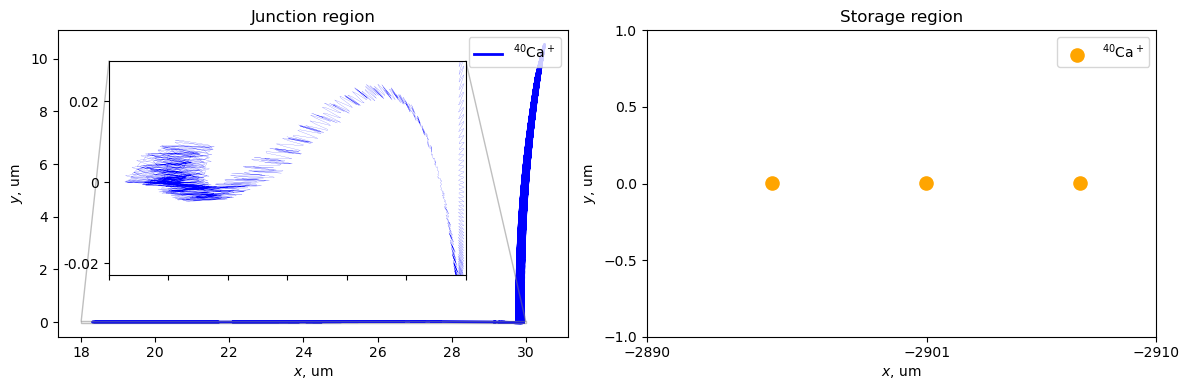

In [68]:
_, data = pl.readdump('logs/poslinshuttle2d_2.txt')
data *=1e6

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]


fig, ax = plt.subplots(1,2,figsize = (12,4))
colors = ['b', 'orange']
ax[0].plot(data[::1, 0, 0],data[::1, 0, 1], color = colors[0], linewidth = 2, label = '$^{40}$Ca$^+$')
for n in range(1, 4):
    if n == 1:
        ax[1].plot(data[30000:, n, 0],data[30000:, n, 1], color = colors[1], linewidth = 1)
        ax[1].scatter(data[-1:, n, 0],data[-1:, n, 1], color = colors[1], s = 90, label = '$^{40}$Ca$^+$')
    else:
        ax[1].plot(data[30000:, n, 0],data[30000:, n, 1], color = colors[1], linewidth = 1)
        ax[1].scatter(data[-1:, n, 0],data[-1:, n, 1], color = colors[1], s = 90)
for n in range(2):
    ax[n].set_xlabel('$x$, um')
    ax[n].set_ylabel('$y$, um')

ax[1].set_xticks([-2910, -2901, -2890])
ax[1].set_yticks([-1, -0.5, 0, 0.5, 1])
ax[1].set_title('Storage region')
ax[1].set_ylim(-1,1)
ax[1].set_xlim(-2890, -2910)

ax[0].set_title('Junction region')

x1, x2, y1, y2 = 18, 30, -0.023, 0.03  # subregion of the original image
axins = ax[0].inset_axes(
    [0.1, 0.2, 0.7, 0.7],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels = [], yticklabels=[-0.02, 0, 0.02])
axins.plot(data[::10, 0, 0],data[::10, 0, 1], color = colors[0], linewidth = 0.1)
axins.set_yticks([-0.02, 0, 0.02])
ax[0].indicate_inset_zoom(axins, edgecolor="gray")
ax[0].legend(loc = 'upper right')
ax[1].legend()
plt.tight_layout()
plt.savefig('images/parallel_trajectories.eps')
plt.show()